In [25]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import dill
import copy
import numpy as np

plt.rcParams["axes.xmargin"] = 0

In [26]:
# Functions to prepare data


def load_pareto_data(dataset_name, num_experiments):
    tunable_data = []
    fixed_data = []
    for file_name in range(0, num_experiments):
        # check if file exists
        try:
            tmp_df = pd.read_csv(f"pareto/{dataset_name}/tunable/{file_name}.csv")
            tunable_data.append(tmp_df)
            tmp_df = pd.read_csv(f"pareto/{dataset_name}/fixed/{file_name}.csv")
            fixed_data.append(tmp_df)
        except:
            continue

    return tunable_data, fixed_data


def prepare_data(data_list, max_lenght=25):
    custom_metrics = []

    new_df = []
    for df in data_list:
        last_name = 0
        tmp_df = []
        for index, row in df[::-1].iterrows():
            name = int(row["Name"].split("-")[-1])
            if name > last_name + 1:
                # add a row with the same values as the previous one
                # but with the new name
                while name > last_name + 1:
                    last_name = last_name + 1
                    new_row = copy.deepcopy(row)
                    new_row["Name"] = last_name + 1
                    tmp_df.append(new_row)
                last_name = name
                tmp_df.append(row)
            else:
                tmp_df.append(row)
                last_name = name
        while last_name < max_lenght:
            last_name = last_name + 1
            new_row = copy.deepcopy(row)
            new_row["Name"] = last_name
            tmp_df.append(new_row)

        # append the new dataframe to the list
        # using the same name of the columns as the previous one
        new_df.append(pd.DataFrame(tmp_df, columns=df.columns))

    for df in new_df:
        custom_metric = list(df["Custom_metric"])[::-1][0:100]

        current_max = 0
        new_custom_metric = []
        for value in custom_metric:
            if value >= current_max:
                current_max = value
            new_custom_metric.append(current_max)

        custom_metrics.append(new_custom_metric)
    return custom_metrics


def create_avg_dataset(new_list):
    # compute the mean and the std of the data in new_list
    # and create a new dataset with these values
    mean = np.mean(new_list, axis=0)
    std = np.std(new_list, axis=0)

    df = pd.DataFrame()
    new_mean = []
    current_max = 0
    for value in mean:
        if value > current_max:
            current_max = value
            new_mean.append(current_max)
        else:
            new_mean.append(None)
    df["mean"] = mean
    df["dots"] = new_mean
    df["std"] = std
    df["index"] = list(range(0, len(mean)))
    return df


def get_df(api_link):
    api = wandb.Api()
    run = api.run(api_link)
    df = pd.DataFrame(run.scan_history())
    return df


def remove_nan(column_names, dataframe):
    column_names = [
        column_name for column_name in column_names if column_name in dataframe.columns
    ]

    current_df = dataframe[column_names]
    # consider each column in training_data_disparity independently and
    # remove the rows where we have NaN
    new_columns = []

    for column in current_df.columns:
        new_values = list(current_df[column].dropna())
        new_columns.append(new_values)

    # if the lists have different lengths, we need to modify them so that
    # we have the same length:
    min_size = min([len(item) for item in new_columns])
    new_columns = [item[:min_size] for item in new_columns]

    # create the new dataframe with baseline_test_nodes_columns_disparity_dataset as columns
    # names and new_columns as values
    new_df = pd.DataFrame(dict(zip(column_names, new_columns)))
    return new_df


def get_experiments(tunable_links, fixed_links, baseline_links):
    tunable_experiments = []
    for link in tunable_links:
        tunable_experiments.append(get_df(link))

    fixed_experiments = []
    for link in fixed_links:
        fixed_experiments.append(get_df(link))

    baseline_experiments = []
    for link in baseline_links:
        baseline_experiments.append(get_df(link))

    return baseline_experiments, tunable_experiments, fixed_experiments


def prepare_mean_and_std(
    tunable_experiments,
    fixed_experiments,
    baseline_experiments,
    accuracy_experiments_type="Train",
    disparity_experiments_type="Training",
):
    tunable_train_accuracy = []
    tunable_train_disparity = []
    for experiment in tunable_experiments:
        experiment = remove_nan(
            [
                accuracy_experiments_type,
                disparity_experiments_type,
            ],
            experiment,
        )
        tunable_train_accuracy.append(list(experiment[accuracy_experiments_type])[0:40])
        tunable_train_disparity.append(
            list(experiment[disparity_experiments_type])[0:40]
        )

    fixed_train_accuracy = []
    fixed_train_disparity = []
    for experiment in fixed_experiments:
        experiment = remove_nan(
            [
                accuracy_experiments_type,
                disparity_experiments_type,
            ],
            experiment,
        )
        fixed_train_accuracy.append(list(experiment[accuracy_experiments_type])[0:40])
        fixed_train_disparity.append(list(experiment[disparity_experiments_type])[0:40])

    fixed_mean_train_accuracy = np.mean(fixed_train_accuracy, axis=0)
    fixed_mean_train_disparity = np.mean(fixed_train_disparity, axis=0)
    if len(fixed_train_accuracy) > 1:
        fixed_std_train_accuracy = np.std(fixed_train_accuracy, axis=0)
        fixed_std_train_disparity = np.std(fixed_train_disparity, axis=0)
    else:
        fixed_std_train_accuracy = fixed_train_accuracy
        fixed_std_train_disparity = fixed_train_disparity

    for item in tunable_train_accuracy:
        print(len(item))

    tunable_mean_train_accuracy = np.mean(tunable_train_accuracy, axis=0)
    tunable_mean_train_disparity = np.mean(tunable_train_disparity, axis=0)
    if len(tunable_train_accuracy) > 1:
        tunable_std_train_accuracy = np.std(tunable_train_accuracy, axis=0)
        tunable_std_train_disparity = np.std(tunable_train_disparity, axis=0)
    else:
        tunable_std_train_accuracy = tunable_train_accuracy
        tunable_std_train_disparity = tunable_train_disparity

    baseline_train_accuracy = []
    baseline_train_disparity = []
    for experiment in baseline_experiments:
        experiment = remove_nan(
            [
                accuracy_experiments_type,
                disparity_experiments_type,
            ],
            experiment,
        )
        baseline_train_accuracy.append(
            list(experiment[accuracy_experiments_type])[0:40]
        )
        baseline_train_disparity.append(
            list(experiment[disparity_experiments_type])[0:40]
        )
    baseline_mean_train_accuracy = np.array([0] * len(tunable_std_train_accuracy))
    baseline_mean_train_disparity = np.array([0] * len(tunable_std_train_accuracy))
    baseline_std_train_accuracy = np.array([0] * len(tunable_std_train_accuracy))
    baseline_std_train_disparity = np.array([0] * len(tunable_std_train_accuracy))
    if len(baseline_experiments) > 0:
        baseline_mean_train_accuracy = np.mean(baseline_train_accuracy, axis=0)
        baseline_mean_train_disparity = np.mean(baseline_train_disparity, axis=0)

        if len(baseline_train_disparity) > 1:
            baseline_std_train_disparity = np.std(baseline_train_disparity, axis=0)
        else:
            baseline_std_train_disparity = baseline_mean_train_disparity
        if len(baseline_train_accuracy) > 1:
            baseline_std_train_accuracy = np.std(baseline_train_accuracy, axis=0)
        else:
            baseline_std_train_accuracy = baseline_mean_train_accuracy

    return (
        baseline_mean_train_accuracy,
        baseline_mean_train_disparity,
        baseline_std_train_accuracy,
        baseline_std_train_disparity,
        fixed_mean_train_accuracy,
        fixed_mean_train_disparity,
        fixed_std_train_accuracy,
        fixed_std_train_disparity,
        tunable_mean_train_accuracy,
        tunable_mean_train_disparity,
        tunable_std_train_accuracy,
        tunable_std_train_disparity,
    )


# Functions to plot
def plot_pareto_frontier(mean_df_tunable, mean_df_fixed):
    plt.figure(figsize=(15, 10))

    # Plot mean as a line
    plt.plot(
        mean_df_tunable["index"],
        mean_df_tunable["mean"],
        label="Tunable Lambda",
        color="blue",
    )
    plt.plot(
        mean_df_fixed["index"],
        mean_df_fixed["mean"],
        label="Fixed Lambda",
        color="green",
    )

    # Plot dots for non-None values in "dots" column
    dots_mask = mean_df_tunable["dots"].notnull()
    plt.scatter(
        mean_df_tunable["index"][dots_mask],
        mean_df_tunable["dots"][dots_mask],
        color="blue",
        marker="o",
    )

    dots_mask = mean_df_fixed["dots"].notnull()
    plt.scatter(
        mean_df_fixed["index"][dots_mask],
        mean_df_fixed["dots"][dots_mask],
        color="green",
        marker="o",
    )

    # Plot std as shaded area
    plt.fill_between(
        mean_df_tunable["index"],
        mean_df_tunable["mean"] - mean_df_tunable["std"],
        mean_df_tunable["mean"] + mean_df_tunable["std"],
        alpha=0.2,
        color="blue",
    )

    plt.fill_between(
        mean_df_fixed["index"],
        mean_df_fixed["mean"] - mean_df_fixed["std"],
        mean_df_fixed["mean"] + mean_df_fixed["std"],
        alpha=0.2,
        color="green",
    )

    # Customize the plot
    plt.title("Fixed vs Tunable Lambda")
    plt.xlabel("Experiments")
    plt.ylabel("Maximixed Metric")
    plt.rcParams.update({"font.size": 22})

    plt.legend(loc="upper left")
    plt.grid(True)
    plt.show()


def plot_accuracy(
    tunable_mean_train_accuracy,
    tunable_std_train_accuracy,
    fixed_mean_train_accuracy,
    fixed_std_train_accuracym,
    baseline_mean_train_accuracy,
    baseline_std_train_accuracy,
    experiment_type="Train",
    num_rounds=39,
    std=True,
):
    # plot train accuracy with fixed and tunable lambda and std
    # Plotting the mean values over time
    plt.figure(figsize=(15, 10))

    x = list(range(0, num_rounds))
    plt.plot(x, tunable_mean_train_accuracy, label="Tunable", color="blue", linewidth=3)
    plt.plot(x, fixed_mean_train_accuracy, label="Fixed", color="green", linewidth=3)
    if not (baseline_mean_train_accuracy == 0).all():
        plt.plot(
            x, baseline_mean_train_accuracy, label="Baseline", color="red", linewidth=3
        )

    # compare the two numpy arrays with all the values
    if std and not (baseline_mean_train_accuracy == baseline_std_train_accuracy).all():
        plt.fill_between(
            x,
            baseline_mean_train_accuracy - baseline_std_train_accuracy,
            baseline_mean_train_accuracy + baseline_std_train_accuracy,
            alpha=0.2,
            color="red",
        )

    if std and not (tunable_mean_train_accuracy == tunable_std_train_accuracy).all():
        # Plotting the standard deviation as an area around the mean
        plt.fill_between(
            x,
            tunable_mean_train_accuracy - tunable_std_train_accuracy,
            tunable_mean_train_accuracy + tunable_std_train_accuracy,
            alpha=0.2,
            color="blue",
        )

    if std and not (fixed_mean_train_accuracy == fixed_std_train_accuracym).all():
        plt.fill_between(
            x,
            fixed_mean_train_accuracy - fixed_std_train_accuracy,
            fixed_mean_train_accuracy + fixed_std_train_accuracy,
            alpha=0.2,
            color="green",
        )

    # Adding labels and title
    plt.xlabel("FL Rounds")
    plt.rcParams.update({"font.size": 22})

    plt.ylabel("Accuracy")
    plt.title(
        f"{experiment_type} Accuracy" + ("- Mean and Standard Deviation" if std else "")
    )
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()


def plot_disparity(
    tunable_mean_train_disparity,
    tunable_std_train_disparity,
    fixed_mean_train_disparity,
    fixed_std_train_disparity,
    baseline_mean_train_disparity,
    baseline_std_train_disparity,
    experiment_type="Train",
    num_rounds=39,
    std=True,
    target=0.1,
):
    # plot train accuracy with fixed and tunable lambda and std
    # Plotting the mean values over time
    plt.figure(figsize=(15, 10))

    x = list(range(0, num_rounds))
    plt.plot(
        x, tunable_mean_train_disparity, label="Tunable", color="blue", linewidth=3
    )
    plt.plot(x, fixed_mean_train_disparity, label="Fixed", color="green", linewidth=3)
    if not (baseline_mean_train_disparity == 0).all():
        plt.plot(
            x, baseline_mean_train_disparity, label="Baseline", color="red", linewidth=3
        )

    if (
        std
        and not (baseline_mean_train_disparity == baseline_std_train_disparity).all()
    ):
        plt.fill_between(
            x,
            baseline_mean_train_disparity - baseline_std_train_disparity,
            baseline_mean_train_disparity + baseline_std_train_disparity,
            alpha=0.2,
            color="red",
        )
    if std and not (tunable_mean_train_disparity == tunable_std_train_disparity).all():
        # Plotting the standard deviation as an area around the mean
        plt.fill_between(
            x,
            tunable_mean_train_disparity - tunable_std_train_disparity,
            tunable_mean_train_disparity + tunable_std_train_disparity,
            alpha=0.2,
            color="blue",
        )

    if std and not (fixed_mean_train_disparity == fixed_std_train_disparity).all():
        plt.fill_between(
            x,
            fixed_mean_train_disparity - fixed_std_train_disparity,
            fixed_mean_train_disparity + fixed_std_train_disparity,
            alpha=0.2,
            color="green",
        )

    # horizontal line indicating the target between 0 and num-rounds
    plt.axhline(
        y=target,
        color="purple",
        linestyle="--",
        linewidth=3,
        label="Target",
        xmin=0,
        xmax=num_rounds,
    )

    # Adding labels and title
    plt.xlabel("FL Rounds")
    plt.rcParams.update({"font.size": 22})

    plt.ylabel("Disparity")
    plt.title(
        f"{experiment_type} Disparity"
        + ("- Mean and Standard Deviation" if std else "")
    )
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()


def plot_single_comparison(
    experiment_lists, num_rounds, legend, target=None, title=None, metric=None
):
    plt.figure(figsize=(15, 10))
    colors = ["blue", "green", "red", "purple", "orange", "black", "pink"]
    x = list(range(0, num_rounds))
    for experiment, color, legend_detail in zip(experiment_lists, colors, legend):
        plt.plot(x, experiment, label=legend_detail, color=color, linewidth=3)
    # horizontal line indicating the target between 0 and num-rounds

    if target:
        plt.axhline(
            y=target,
            color="purple",
            linestyle="--",
            linewidth=3,
            label="Target",
            xmin=0,
            xmax=num_rounds,
        )

    # Adding labels and title
    plt.xlabel("FL Rounds")
    plt.rcParams.update({"font.size": 22})

    plt.ylabel("Disparity")
    plt.title(title)
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()


def plot_comparison(
    baseline,
    tunable,
    fixed,
    tunable_weighted,
    # fixed_weighted,
    tunable_1_weighted,
    fixed_1_weighted,
    num_rounds,
    target=None,
    title=None,
):
    experiments = [
        baseline,
        tunable,
        fixed,
        tunable_weighted,
        # fixed_weighted,
        tunable_1_weighted,
        fixed_1_weighted,
    ]
    train_accuracy = [
        remove_nan(["Train Accuracy"], experiment) for experiment in experiments
    ]
    validation_accuracy = [
        remove_nan(["Validation_Accuracy"], experiment) for experiment in experiments
    ]
    test_accuracy = [
        remove_nan(["Test Accuracy"], experiment) for experiment in experiments
    ]
    train_disparity = [
        remove_nan(["Training Disparity with statistics no noise"], experiment)
        for experiment in experiments
    ]
    validation_disparity = [
        remove_nan(["Validation Disparity with statistics"], experiment)
        for experiment in experiments
    ]
    test_disparity = [
        remove_nan(["Test Disparity with statistics"], experiment)
        for experiment in experiments
    ]

    legend = [
        "Baseline",
        "Tunable",
        "Fixed",
        "Tunable weighted",
        # "Fixed weighted",
        "Tunable 1/L weighted",
        "Fixed 1/L weighted",
    ]

    # plot train accuracy with fixed and tunable lambda
    plot_single_comparison(
        train_accuracy,
        num_rounds,
        legend,
        target=None,
        title="Train accuracy",
        metric="Train Accuracy",
    )
    plot_single_comparison(
        test_accuracy,
        num_rounds,
        legend,
        target=None,
        title="Test accuracy",
        metric="Test Accuracy",
    )
    plot_single_comparison(
        validation_accuracy,
        num_rounds,
        legend,
        target=None,
        title="Validation accuracy",
        metric="Validation_Accuracy",
    )

    plot_single_comparison(
        train_disparity,
        num_rounds,
        legend,
        target,
        title="Train Disparity",
        metric="Training Disparity with statistics no noise",
    )
    plot_single_comparison(
        validation_disparity,
        num_rounds,
        legend,
        target,
        title="Validation Disparity",
        metric="Validation Disparity with statistics",
    )
    plot_single_comparison(
        test_disparity,
        num_rounds,
        legend,
        target,
        title="Test Disparity",
        metric="Test Disparity with statistics",
    )

# Celeba Proba

### Pareto Frontier

In [27]:
tunable_data, fixed_data = load_pareto_data("celeba_proba", 4)
new_list_tunable = prepare_data(tunable_data, max_lenght=30)
mean_df_tunable = create_avg_dataset(new_list_tunable)

In [28]:
new_list_fixed = prepare_data(fixed_data, max_lenght=30)
new_list_fixed[3] = new_list_fixed[3][:30]
mean_df_fixed = create_avg_dataset(new_list_fixed)

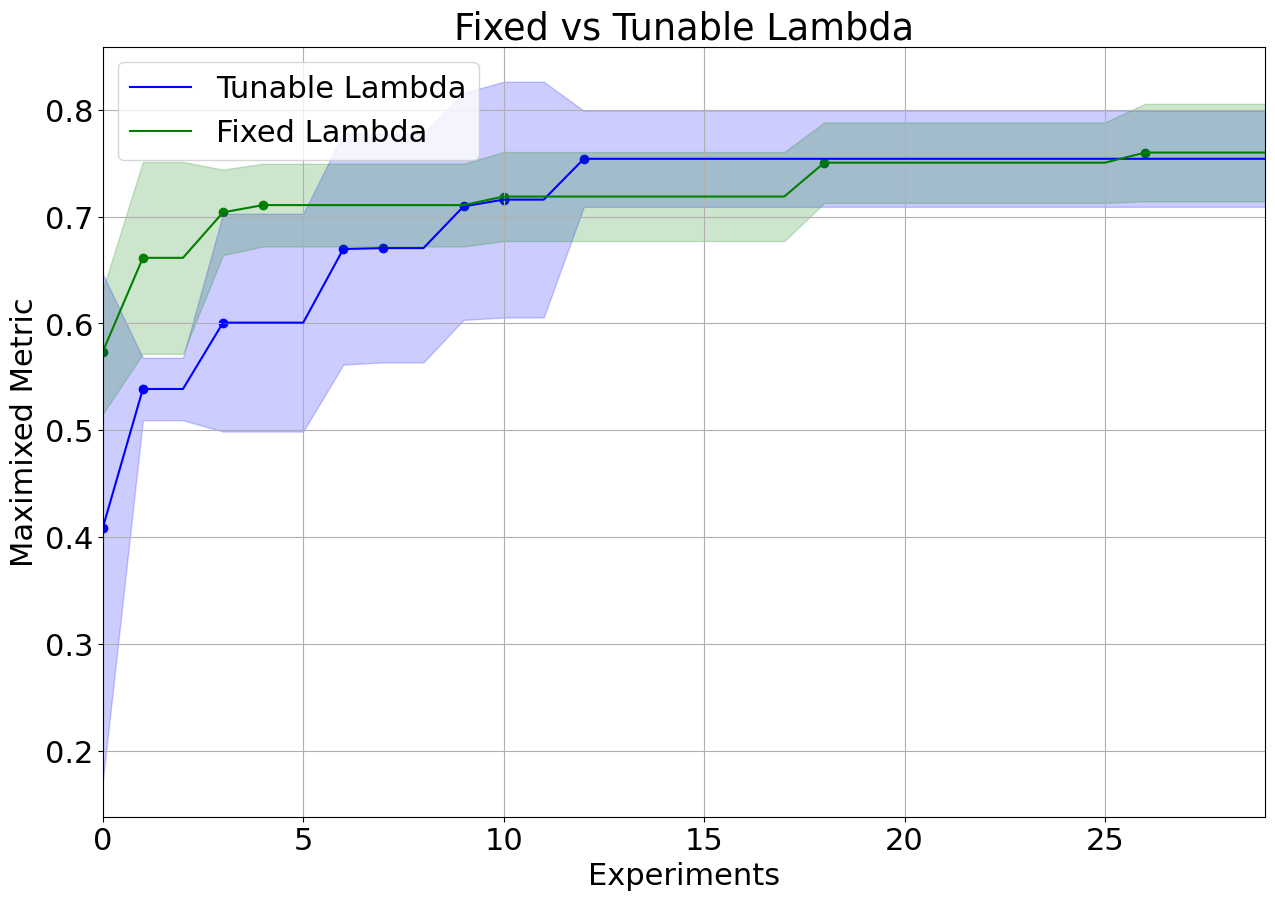

In [29]:
plot_pareto_frontier(mean_df_tunable, mean_df_fixed)

### Training and Test accuracy/disparity

In [30]:
tunable_links = [
    "/lucacorbucci/FL_PUF_Sweep/runs/vijzw5e2",
    "/lucacorbucci/FL_PUF_Sweep/runs/ea9gxqp7",
    "/lucacorbucci/FL_PUF_Sweep/runs/jagm039x",
    "/lucacorbucci/FL_PUF_Sweep/runs/vdd95bve",
    # "/lucacorbucci/FL_PUF_Sweep/runs/mz3flegg",
    # "/lucacorbucci/FL_PUF_Sweep/runs/z7jrp3k9",
    # "/lucacorbucci/FL_PUF_Sweep/runs/0xfozoth",
    # "/lucacorbucci/FL_PUF_Sweep/runs/njp3n3mq",
    # "/lucacorbucci/FL_PUF_Sweep/runs/cbgr0zul",
    # "/lucacorbucci/FL_PUF_Sweep/runs/d65epyt1",
]
fixed_links = [
    "/lucacorbucci/FL_PUF_Sweep/runs/k834ehwb",
    "/lucacorbucci/FL_PUF_Sweep/runs/8qu8egw7",
    "/lucacorbucci/FL_PUF_Sweep/runs/afo7lx1e",
    "/lucacorbucci/FL_PUF_Sweep/runs/mb1oqvwn",
    # "/lucacorbucci/FL_PUF_Sweep/runs/6v76gh5f",
    # "/lucacorbucci/FL_PUF_Sweep/runs/alq0t0b4",
    # "/lucacorbucci/FL_PUF_Sweep/runs/rkn3aiq8",
    # "/lucacorbucci/FL_PUF_Sweep/runs/5bupft66",
    # "/lucacorbucci/FL_PUF_Sweep/runs/7ledzo4i",
    # "/lucacorbucci/FL_PUF_Sweep/runs/8ucmq64e",
]

baseline_links = [
    "/lucacorbucci/FL_PUF_Sweep/runs/1mydhwdu",
    "/lucacorbucci/FL_PUF_Sweep/runs/cis5l1vv",
    "/lucacorbucci/FL_PUF_Sweep/runs/uqwx9sw7",
]

In [31]:
baseline_experiments, tunable_experiments, fixed_experiments = get_experiments(
    tunable_links, fixed_links, baseline_links
)

In [32]:
(
    baseline_mean_train_accuracy,
    baseline_mean_train_disparity,
    baseline_std_train_accuracy,
    baseline_std_train_disparity,
    fixed_mean_train_accuracy,
    fixed_mean_train_disparity,
    fixed_std_train_accuracy,
    fixed_std_train_disparity,
    tunable_mean_train_accuracy,
    tunable_mean_train_disparity,
    tunable_std_train_accuracy,
    tunable_std_train_disparity,
) = prepare_mean_and_std(
    tunable_experiments,
    fixed_experiments,
    baseline_experiments,
    accuracy_experiments_type="Train Accuracy",
    disparity_experiments_type="Training Disparity with statistics no noise",
)

39
39
39
39


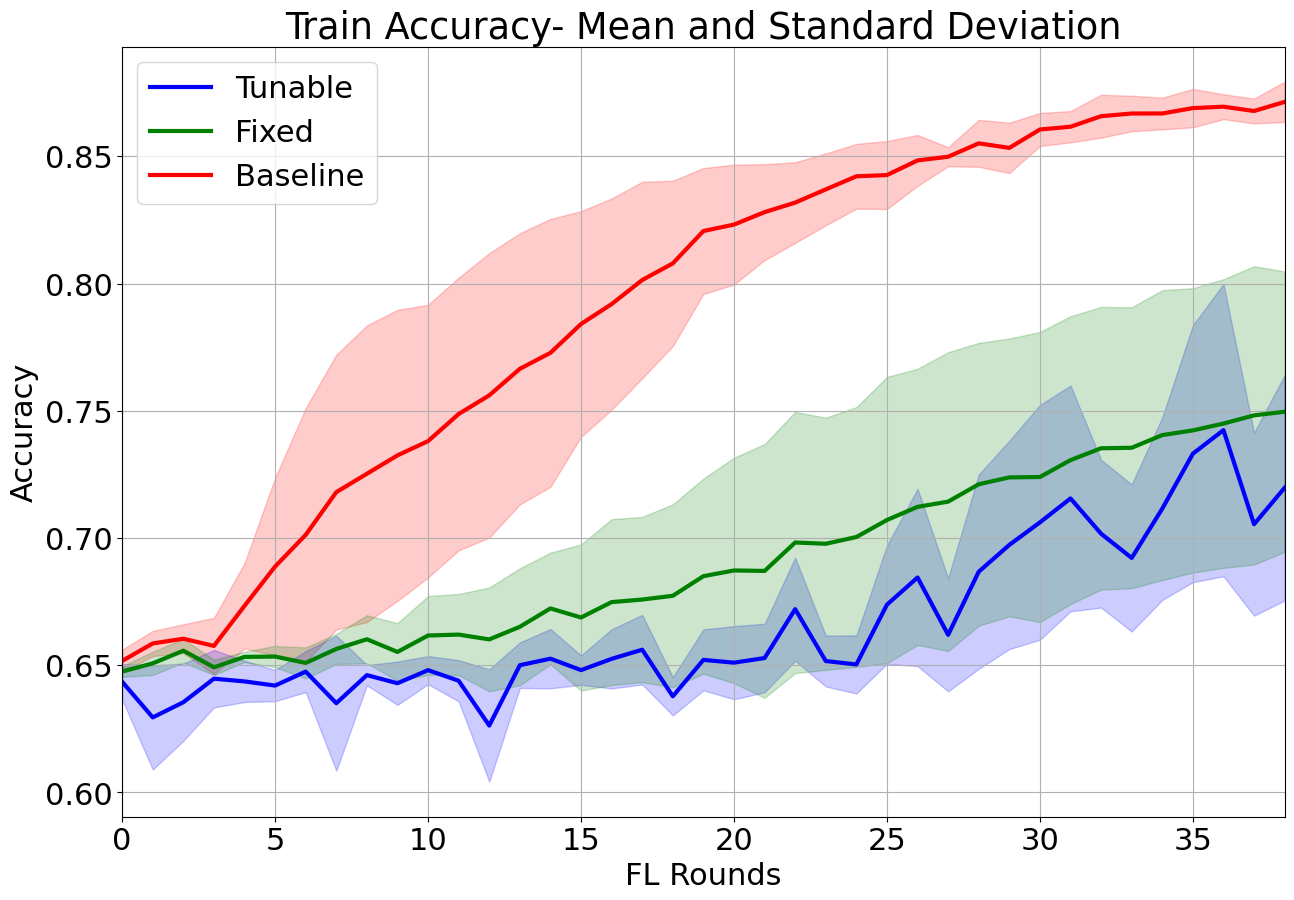

In [33]:
plot_accuracy(
    tunable_mean_train_accuracy,
    tunable_std_train_accuracy,
    fixed_mean_train_accuracy,
    fixed_std_train_accuracy,
    baseline_mean_train_accuracy,
    baseline_std_train_accuracy,
    experiment_type="Train",
)

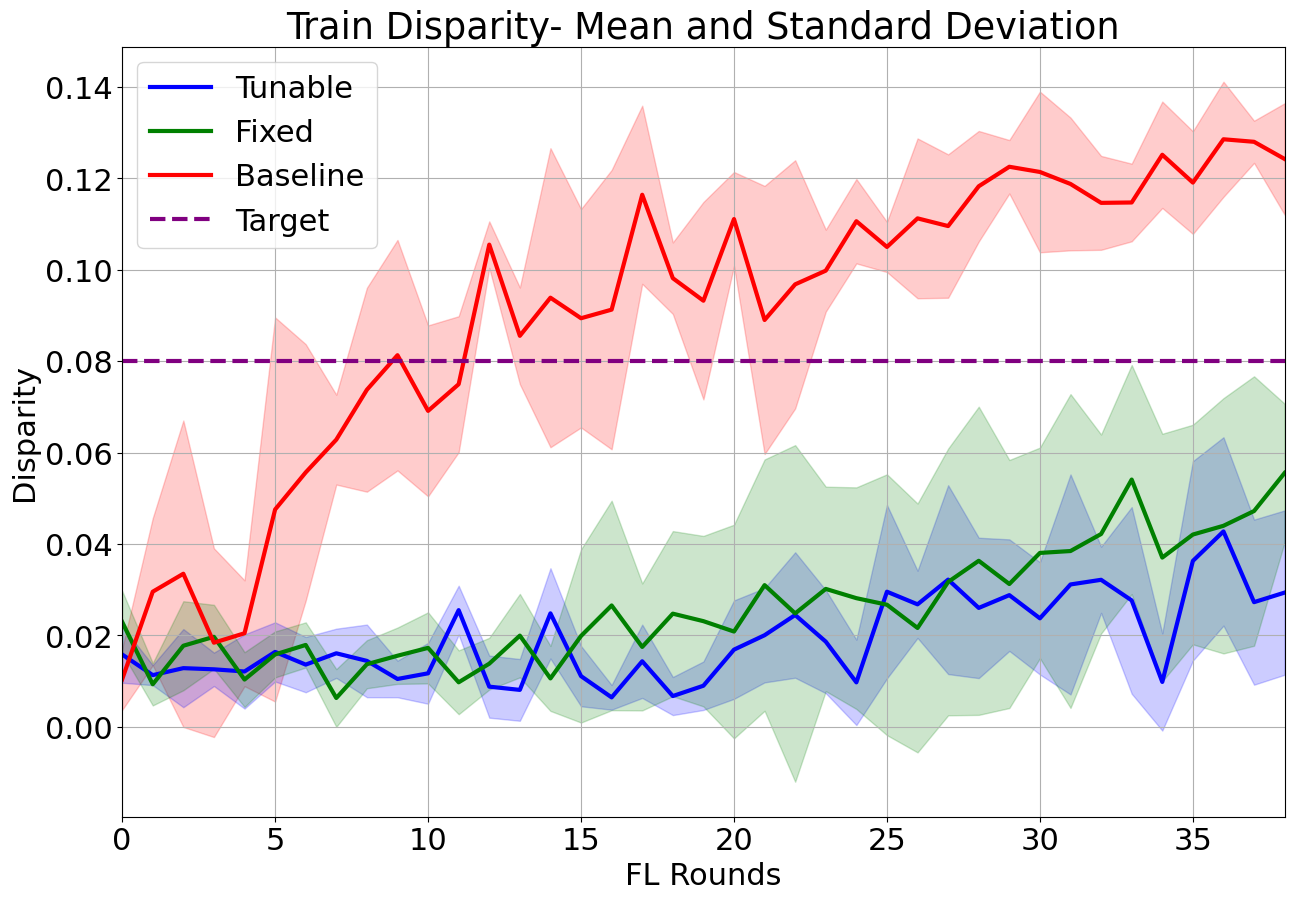

In [34]:
plot_disparity(
    tunable_mean_train_disparity,
    tunable_std_train_disparity,
    fixed_mean_train_disparity,
    fixed_std_train_disparity,
    baseline_mean_train_disparity,
    baseline_std_train_disparity,
    experiment_type="Train",
    target=0.08,
)

In [35]:
(
    baseline_mean_train_accuracy,
    baseline_mean_train_disparity,
    baseline_std_train_accuracy,
    baseline_std_train_disparity,
    fixed_mean_train_accuracy,
    fixed_mean_train_disparity,
    fixed_std_train_accuracy,
    fixed_std_train_disparity,
    tunable_mean_train_accuracy,
    tunable_mean_train_disparity,
    tunable_std_train_accuracy,
    tunable_std_train_disparity,
) = prepare_mean_and_std(
    tunable_experiments,
    fixed_experiments,
    baseline_experiments,
    accuracy_experiments_type="Validation_Accuracy",
    disparity_experiments_type="Validation Disparity with statistics",
)

39
39
39
39


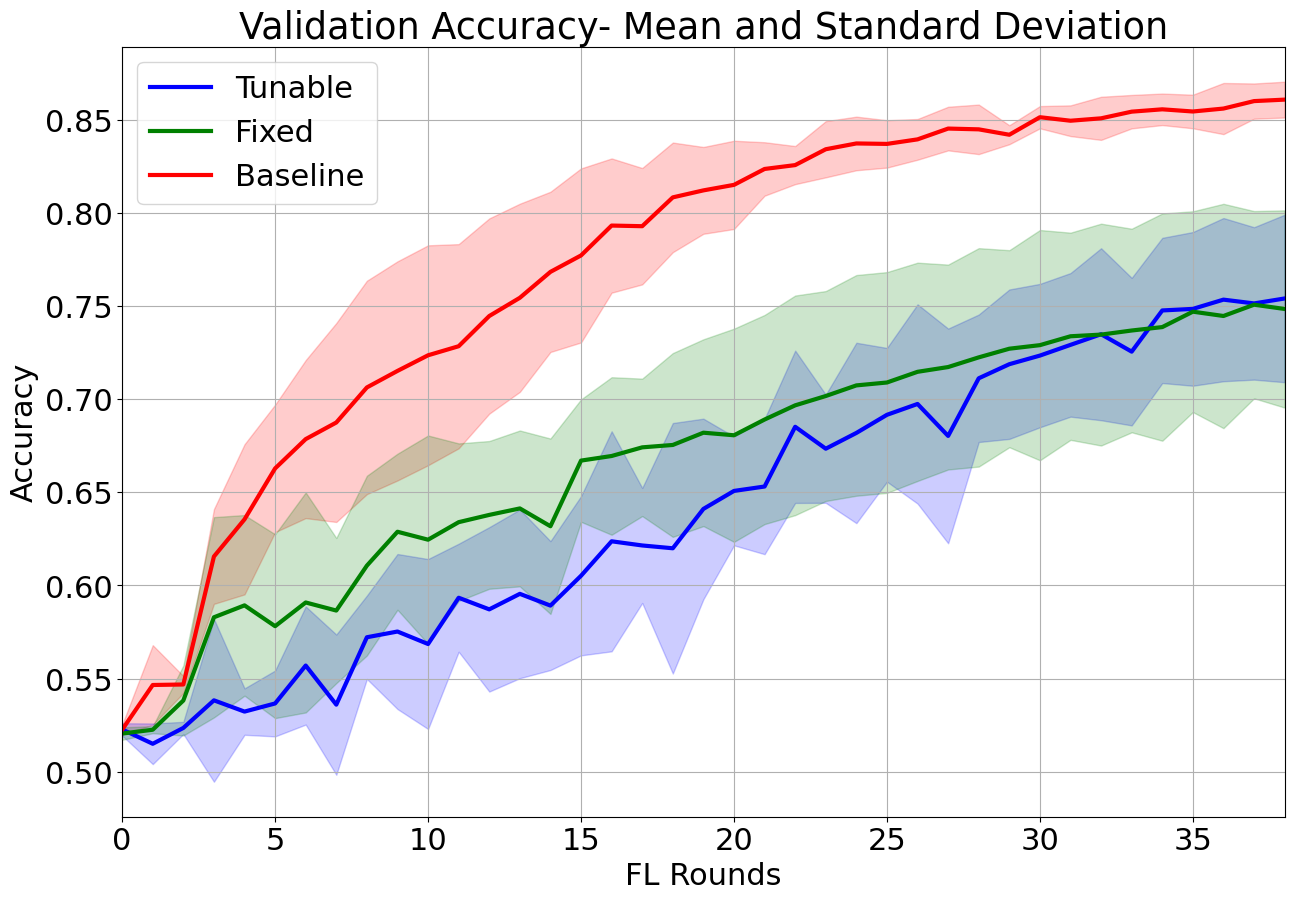

In [36]:
plot_accuracy(
    tunable_mean_train_accuracy,
    tunable_std_train_accuracy,
    fixed_mean_train_accuracy,
    fixed_std_train_accuracy,
    baseline_mean_train_accuracy,
    baseline_std_train_accuracy,
    experiment_type="Validation",
)

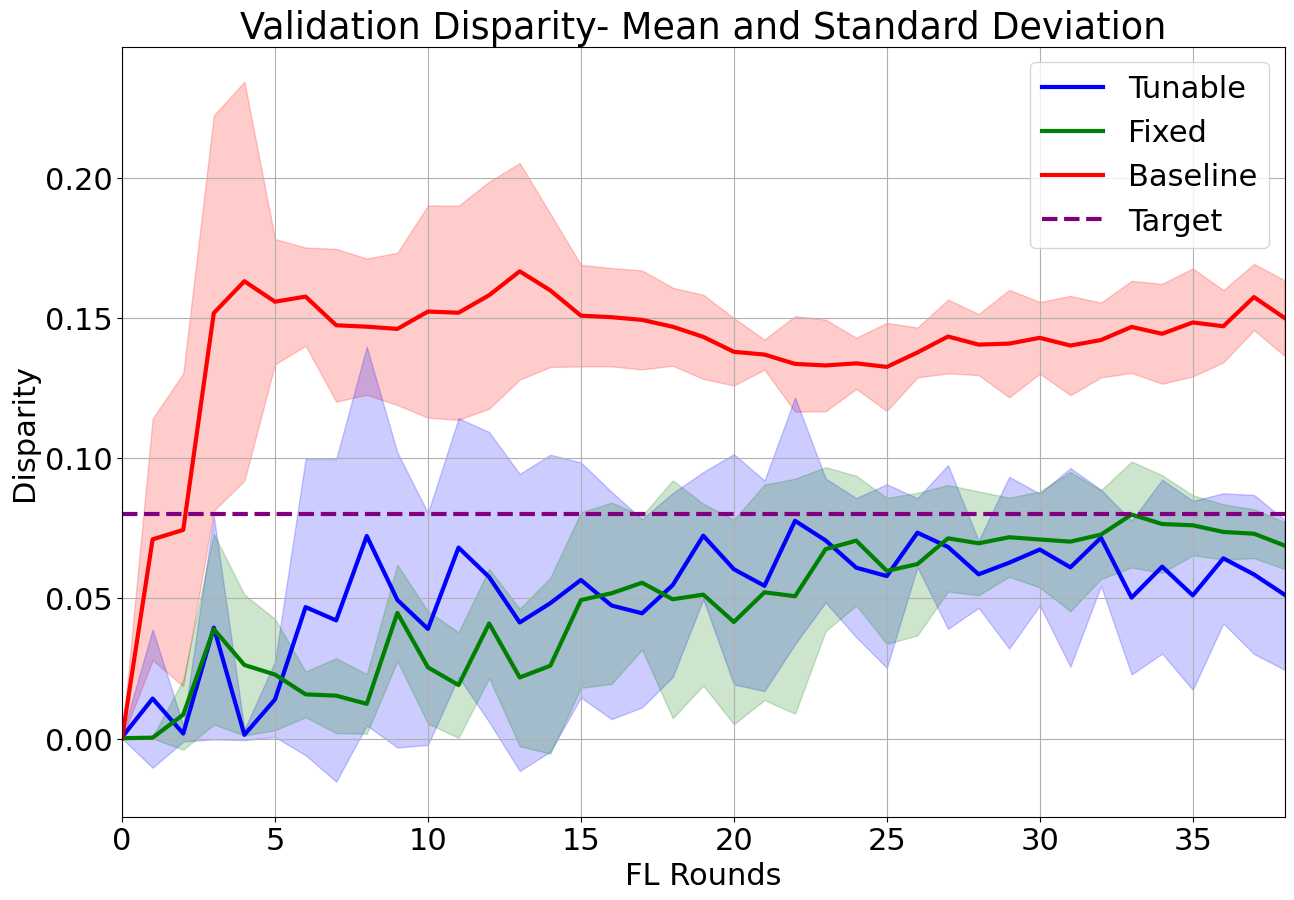

In [37]:
plot_disparity(
    tunable_mean_train_disparity,
    tunable_std_train_disparity,
    fixed_mean_train_disparity,
    fixed_std_train_disparity,
    baseline_mean_train_disparity,
    baseline_std_train_disparity,
    experiment_type="Validation",
    target=0.08,
)

In [38]:
(
    baseline_mean_test_accuracy,
    baseline_mean_test_disparity,
    baseline_std_test_accuracy,
    baseline_std_test_disparity,
    fixed_mean_test_accuracy,
    fixed_mean_test_disparity,
    fixed_std_test_accuracy,
    fixed_std_test_disparity,
    tunable_mean_test_accuracy,
    tunable_mean_test_disparity,
    tunable_std_test_accuracy,
    tunable_std_test_disparity,
) = prepare_mean_and_std(
    tunable_experiments,
    fixed_experiments,
    baseline_experiments,
    accuracy_experiments_type="Test Accuracy",
    disparity_experiments_type="Test Disparity with statistics",
)

39
39
39
39


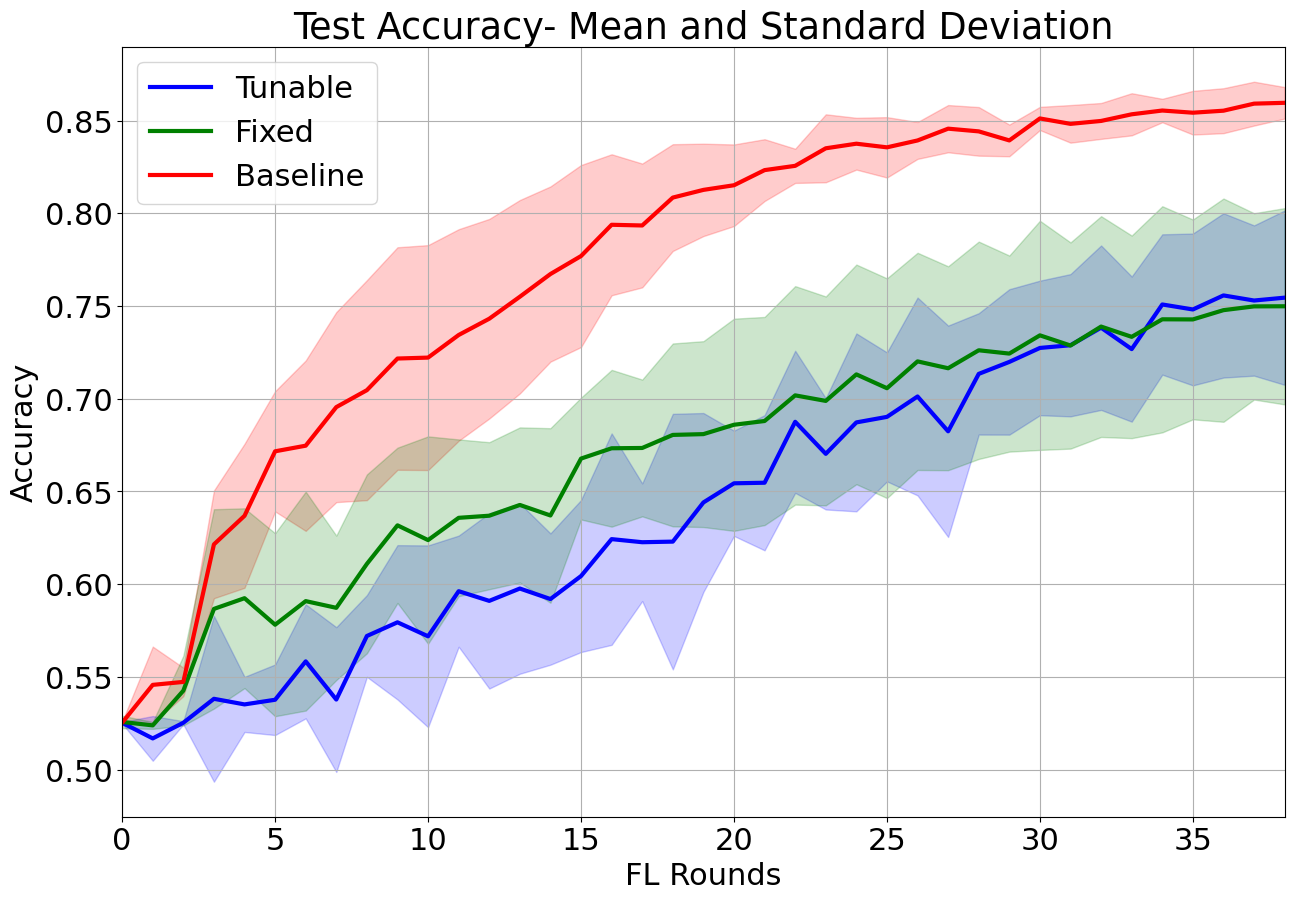

In [39]:
plot_accuracy(
    tunable_mean_test_accuracy,
    tunable_std_test_accuracy,
    fixed_mean_test_accuracy,
    fixed_std_test_accuracy,
    baseline_mean_test_accuracy,
    baseline_std_test_accuracy,
    experiment_type="Test",
)

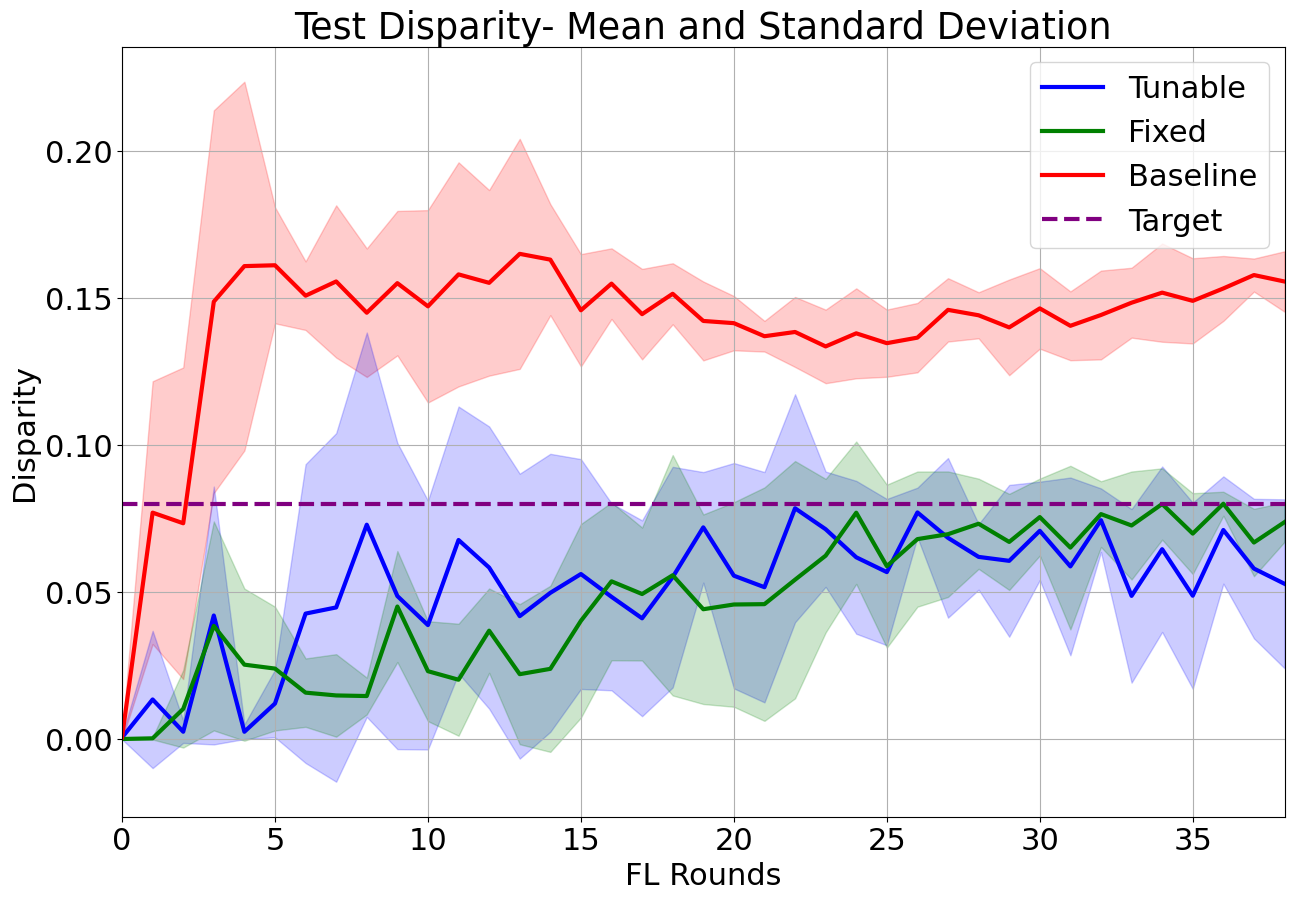

In [40]:
plot_disparity(
    tunable_mean_test_disparity,
    tunable_std_test_disparity,
    fixed_mean_test_disparity,
    fixed_std_test_disparity,
    baseline_mean_test_disparity,
    baseline_std_test_disparity,
    experiment_type="Test",
    target=0.08,
)

# Dutch Proba

In [ ]:
tunable_links = [
    "/lucacorbucci/FL_PUF_Sweep/runs/vijzw5e2",
    # "/lucacorbucci/FL_PUF_Sweep/runs/ea9gxqp7",
    # "/lucacorbucci/FL_PUF_Sweep/runs/jagm039x",
    # "/lucacorbucci/FL_PUF_Sweep/runs/vdd95bve",
    # "/lucacorbucci/FL_PUF_Sweep/runs/mz3flegg",
    # "/lucacorbucci/FL_PUF_Sweep/runs/z7jrp3k9",
    # "/lucacorbucci/FL_PUF_Sweep/runs/0xfozoth",
    # "/lucacorbucci/FL_PUF_Sweep/runs/njp3n3mq",
    # "/lucacorbucci/FL_PUF_Sweep/runs/cbgr0zul",
    # "/lucacorbucci/FL_PUF_Sweep/runs/d65epyt1",
]
fixed_links = [
    "/lucacorbucci/FL_PUF_Sweep/runs/k834ehwb",
    # "/lucacorbucci/FL_PUF_Sweep/runs/8qu8egw7",
    # "/lucacorbucci/FL_PUF_Sweep/runs/afo7lx1e",
    # "/lucacorbucci/FL_PUF_Sweep/runs/mb1oqvwn",
    # "/lucacorbucci/FL_PUF_Sweep/runs/6v76gh5f",
    # "/lucacorbucci/FL_PUF_Sweep/runs/alq0t0b4",
    # "/lucacorbucci/FL_PUF_Sweep/runs/rkn3aiq8",
    # "/lucacorbucci/FL_PUF_Sweep/runs/5bupft66",
    # "/lucacorbucci/FL_PUF_Sweep/runs/7ledzo4i",
    # "/lucacorbucci/FL_PUF_Sweep/runs/8ucmq64e",
]

baseline_links = [
    "/lucacorbucci/FL_PUF_Sweep/runs/y5ghikxf",
]

In [ ]:
# baseline_experiments, tunable_experiments, fixed_experiments = get_experiments(
#     tunable_links, fixed_links, baseline_links
# )

In [ ]:
(
    baseline_mean_train_accuracy,
    baseline_mean_train_disparity,
    baseline_std_train_accuracy,
    baseline_std_train_disparity,
    fixed_mean_train_accuracy,
    fixed_mean_train_disparity,
    fixed_std_train_accuracy,
    fixed_std_train_disparity,
    tunable_mean_train_accuracy,
    tunable_mean_train_disparity,
    tunable_std_train_accuracy,
    tunable_std_train_disparity,
) = prepare_mean_and_std(
    tunable_experiments,
    fixed_experiments,
    baseline_experiments,
    accuracy_experiments_type="Train Accuracy",
    disparity_experiments_type="Training Disparity with statistics no noise",
)

In [ ]:
plot_accuracy(
    tunable_mean_train_accuracy,
    tunable_std_train_accuracy,
    fixed_mean_train_accuracy,
    fixed_std_train_accuracy,
    baseline_mean_train_accuracy,
    baseline_std_train_accuracy,
    experiment_type="Train",
)

In [ ]:
plot_disparity(
    tunable_mean_train_disparity,
    tunable_std_train_disparity,
    fixed_mean_train_disparity,
    fixed_std_train_disparity,
    baseline_mean_train_disparity,
    baseline_std_train_disparity,
    experiment_type="Train",
)

In [ ]:
(
    baseline_mean_train_accuracy,
    baseline_mean_train_disparity,
    baseline_std_train_accuracy,
    baseline_std_train_disparity,
    fixed_mean_train_accuracy,
    fixed_mean_train_disparity,
    fixed_std_train_accuracy,
    fixed_std_train_disparity,
    tunable_mean_train_accuracy,
    tunable_mean_train_disparity,
    tunable_std_train_accuracy,
    tunable_std_train_disparity,
) = prepare_mean_and_std(
    tunable_experiments,
    fixed_experiments,
    baseline_experiments,
    accuracy_experiments_type="Validation_Accuracy",
    disparity_experiments_type="Validation Disparity with statistics",
)

In [ ]:
plot_accuracy(
    tunable_mean_train_accuracy,
    tunable_std_train_accuracy,
    fixed_mean_train_accuracy,
    fixed_std_train_accuracy,
    baseline_mean_train_accuracy,
    baseline_std_train_accuracy,
    experiment_type="Validation",
)

In [ ]:
plot_disparity(
    tunable_mean_train_disparity,
    tunable_std_train_disparity,
    fixed_mean_train_disparity,
    fixed_std_train_disparity,
    baseline_mean_train_disparity,
    baseline_std_train_disparity,
    experiment_type="Validation",
)

In [ ]:
(
    baseline_mean_test_accuracy,
    baseline_mean_test_disparity,
    baseline_std_test_accuracy,
    baseline_std_test_disparity,
    fixed_mean_test_accuracy,
    fixed_mean_test_disparity,
    fixed_std_test_accuracy,
    fixed_std_test_disparity,
    tunable_mean_test_accuracy,
    tunable_mean_test_disparity,
    tunable_std_test_accuracy,
    tunable_std_test_disparity,
) = prepare_mean_and_std(
    tunable_experiments,
    fixed_experiments,
    baseline_experiments,
    accuracy_experiments_type="Test Accuracy",
    disparity_experiments_type="Test Disparity with statistics",
)

In [ ]:
plot_accuracy(
    tunable_mean_test_accuracy,
    tunable_std_test_accuracy,
    fixed_mean_test_accuracy,
    fixed_std_test_accuracy,
    baseline_mean_test_accuracy,
    baseline_std_test_accuracy,
    experiment_type="Test",
)

In [ ]:
plot_disparity(
    tunable_mean_test_disparity,
    tunable_std_test_disparity,
    fixed_mean_test_disparity,
    fixed_std_test_disparity,
    baseline_mean_test_disparity,
    baseline_std_test_disparity,
    experiment_type="Test",
)

# Different Targets Dutch 

### 1.0

### Pareto Frontier

In [3]:
tunable_data, fixed_data = load_pareto_data("dutch_10", 4)
new_list_tunable = prepare_data(tunable_data, max_lenght=25)
mean_df_tunable = create_avg_dataset(new_list_tunable)

In [4]:
new_list_fixed = prepare_data(fixed_data, max_lenght=25)
# new_list_fixed[3] = new_list_fixed[3][:30]
mean_df_fixed = create_avg_dataset(new_list_fixed)

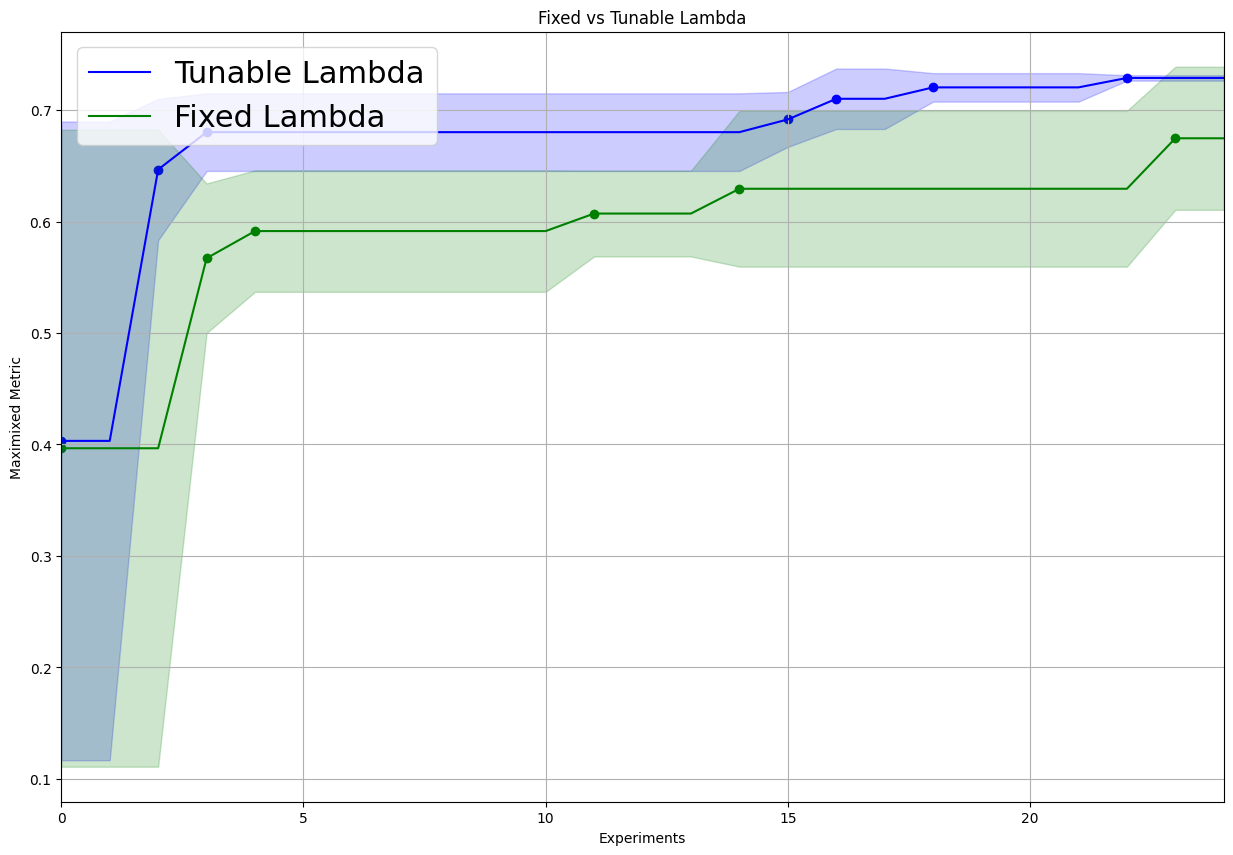

In [5]:
plot_pareto_frontier(mean_df_tunable, mean_df_fixed)

### Training and Test accuracy/disparity

In [6]:
tunable_links = [
    "/lucacorbucci/FL_PUF_Sweep/runs/i25mwhig",
    "/lucacorbucci/FL_PUF_Sweep/runs/tdlrbm5w",
    "/lucacorbucci/FL_PUF_Sweep/runs/622zzfdh",
    # "/lucacorbucci/FL_PUF_Sweep/runs/mz3flegg",
    # "/lucacorbucci/FL_PUF_Sweep/runs/z7jrp3k9",
    # "/lucacorbucci/FL_PUF_Sweep/runs/0xfozoth",
    # "/lucacorbucci/FL_PUF_Sweep/runs/njp3n3mq",
    # "/lucacorbucci/FL_PUF_Sweep/runs/cbgr0zul",
    # "/lucacorbucci/FL_PUF_Sweep/runs/d65epyt1",
]
fixed_links = [
    "/lucacorbucci/FL_PUF_Sweep/runs/knp1l3kw",
    "/lucacorbucci/FL_PUF_Sweep/runs/2pw3yxd1",
    "/lucacorbucci/FL_PUF_Sweep/runs/rq3s2im0",
    # "/lucacorbucci/FL_PUF_Sweep/runs/6v76gh5f",
    # "/lucacorbucci/FL_PUF_Sweep/runs/alq0t0b4",
    # "/lucacorbucci/FL_PUF_Sweep/runs/rkn3aiq8",
    # "/lucacorbucci/FL_PUF_Sweep/runs/5bupft66",
    # "/lucacorbucci/FL_PUF_Sweep/runs/7ledzo4i",
    # "/lucacorbucci/FL_PUF_Sweep/runs/8ucmq64e",
]

baseline_links = [
    "/lucacorbucci/FL_PUF_Sweep/runs/lkdrj4ib",
    "/lucacorbucci/FL_PUF_Sweep/runs/8669og1q",
    "/lucacorbucci/FL_PUF_Sweep/runs/jsn812nl",
]

In [7]:
baseline_experiments, tunable_experiments, fixed_experiments = get_experiments(
    tunable_links, fixed_links, baseline_links
)

In [8]:
(
    baseline_mean_train_accuracy,
    baseline_mean_train_disparity,
    baseline_std_train_accuracy,
    baseline_std_train_disparity,
    fixed_mean_train_accuracy,
    fixed_mean_train_disparity,
    fixed_std_train_accuracy,
    fixed_std_train_disparity,
    tunable_mean_train_accuracy,
    tunable_mean_train_disparity,
    tunable_std_train_accuracy,
    tunable_std_train_disparity,
) = prepare_mean_and_std(
    tunable_experiments,
    fixed_experiments,
    baseline_experiments,
    accuracy_experiments_type="Train Accuracy",
    disparity_experiments_type="Training Disparity with statistics no noise",
)

39
39
39


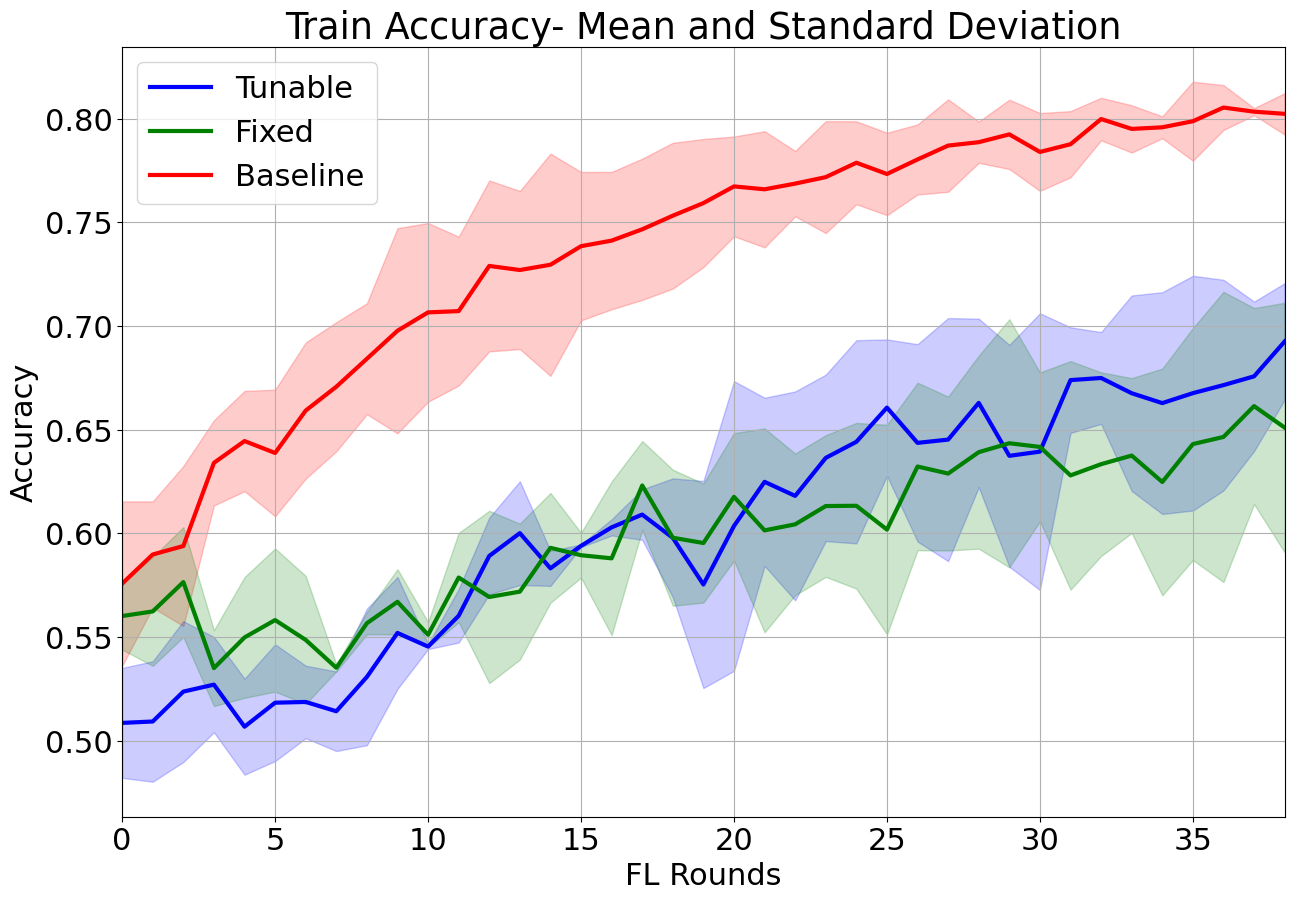

In [9]:
plot_accuracy(
    tunable_mean_train_accuracy,
    tunable_std_train_accuracy,
    fixed_mean_train_accuracy,
    fixed_std_train_accuracy,
    baseline_mean_train_accuracy,
    baseline_std_train_accuracy,
    experiment_type="Train",
)

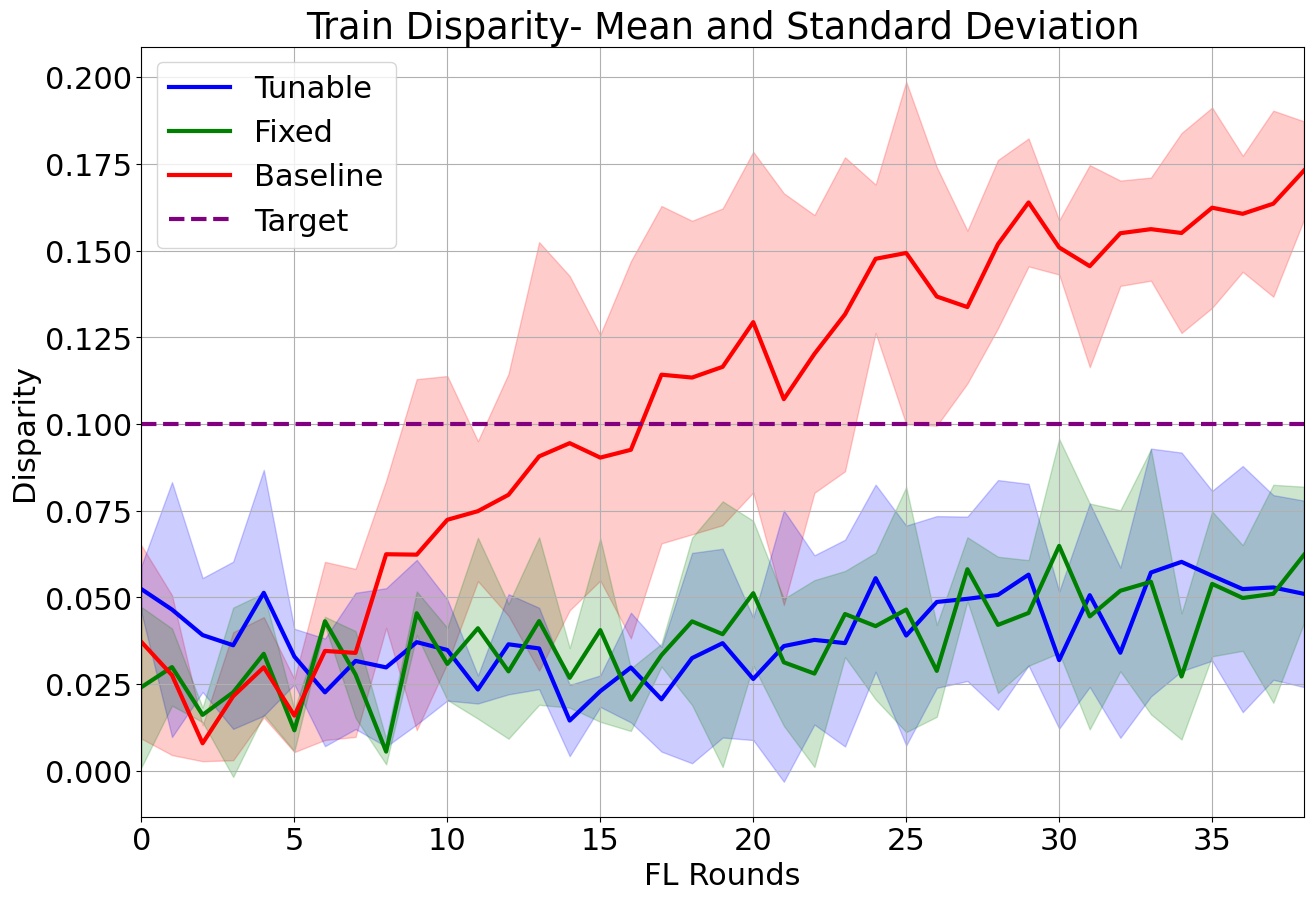

In [10]:
plot_disparity(
    tunable_mean_train_disparity,
    tunable_std_train_disparity,
    fixed_mean_train_disparity,
    fixed_std_train_disparity,
    baseline_mean_train_disparity,
    baseline_std_train_disparity,
    experiment_type="Train",
)

In [12]:
(
    baseline_mean_train_accuracy,
    baseline_mean_train_disparity,
    baseline_std_train_accuracy,
    baseline_std_train_disparity,
    fixed_mean_train_accuracy,
    fixed_mean_train_disparity,
    fixed_std_train_accuracy,
    fixed_std_train_disparity,
    tunable_mean_train_accuracy,
    tunable_mean_train_disparity,
    tunable_std_train_accuracy,
    tunable_std_train_disparity,
) = prepare_mean_and_std(
    tunable_experiments,
    fixed_experiments,
    baseline_experiments,
    accuracy_experiments_type="Validation_Accuracy",
    disparity_experiments_type="Validation Disparity with statistics",
)

39
39
39


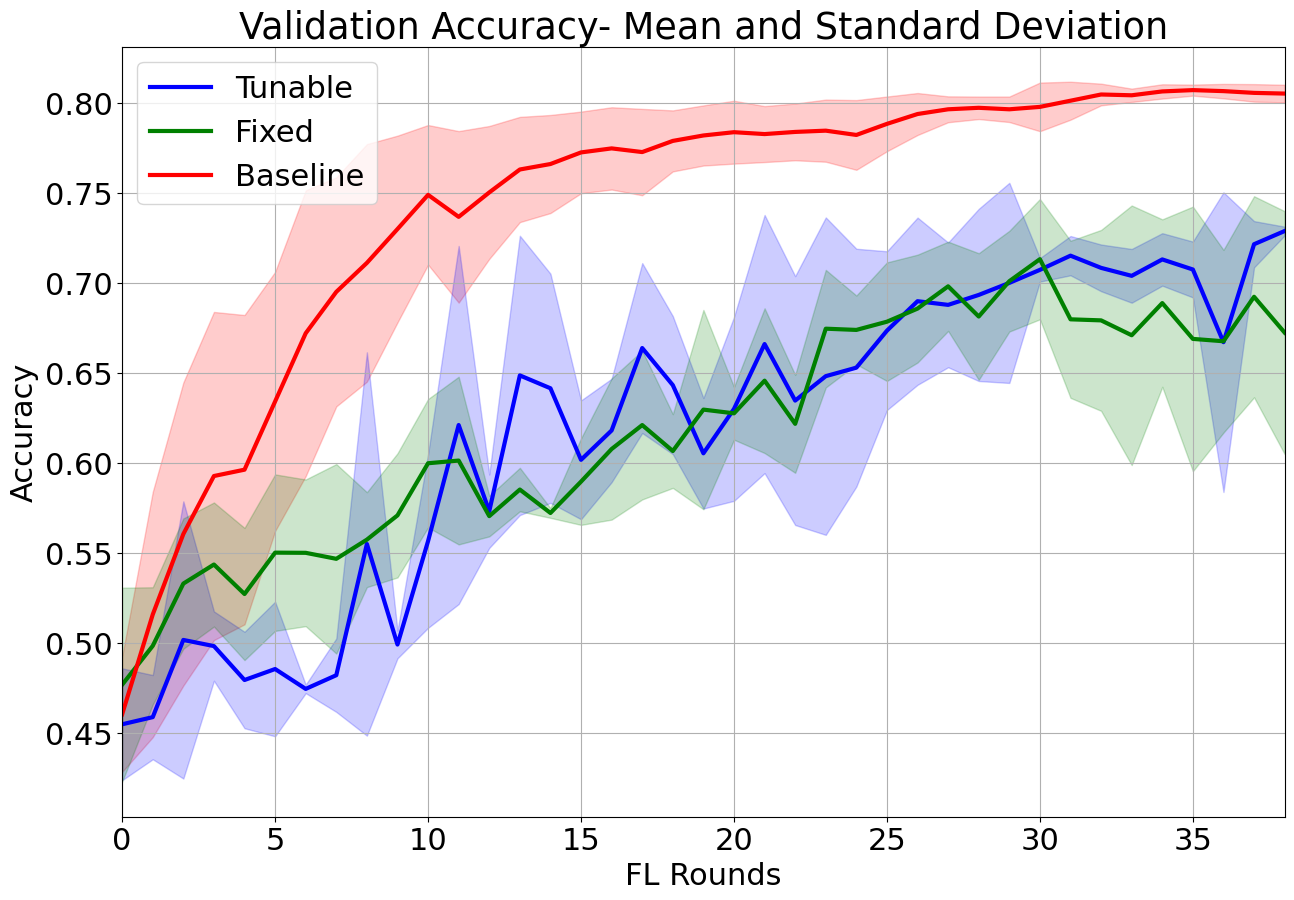

In [13]:
plot_accuracy(
    tunable_mean_train_accuracy,
    tunable_std_train_accuracy,
    fixed_mean_train_accuracy,
    fixed_std_train_accuracy,
    baseline_mean_train_accuracy,
    baseline_std_train_accuracy,
    experiment_type="Validation",
)

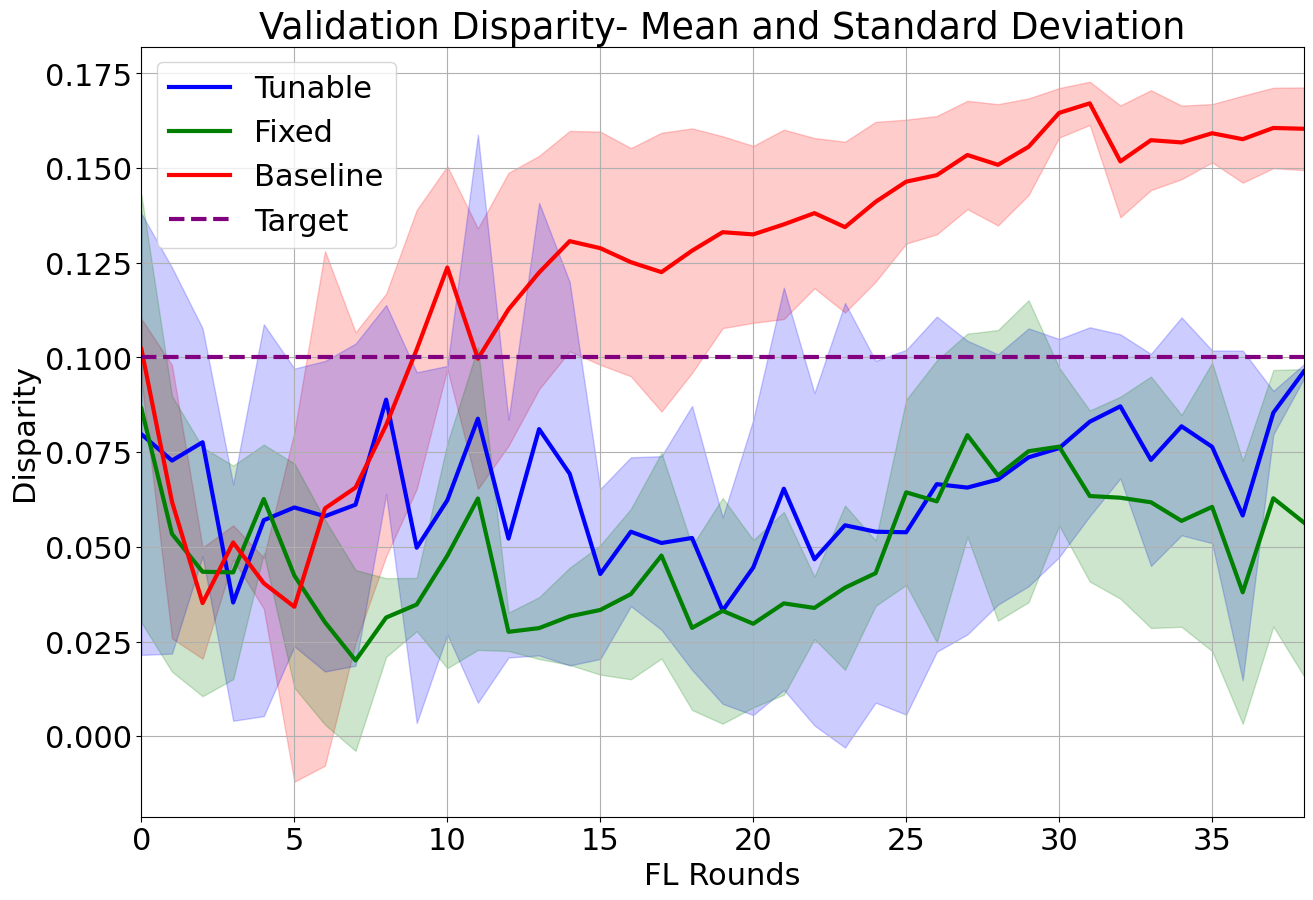

In [14]:
plot_disparity(
    tunable_mean_train_disparity,
    tunable_std_train_disparity,
    fixed_mean_train_disparity,
    fixed_std_train_disparity,
    baseline_mean_train_disparity,
    baseline_std_train_disparity,
    experiment_type="Validation",
)

In [15]:
(
    baseline_mean_test_accuracy,
    baseline_mean_test_disparity,
    baseline_std_test_accuracy,
    baseline_std_test_disparity,
    fixed_mean_test_accuracy,
    fixed_mean_test_disparity,
    fixed_std_test_accuracy,
    fixed_std_test_disparity,
    tunable_mean_test_accuracy,
    tunable_mean_test_disparity,
    tunable_std_test_accuracy,
    tunable_std_test_disparity,
) = prepare_mean_and_std(
    tunable_experiments,
    fixed_experiments,
    baseline_experiments,
    accuracy_experiments_type="Test Accuracy",
    disparity_experiments_type="Test Disparity with statistics",
)

39
39
39


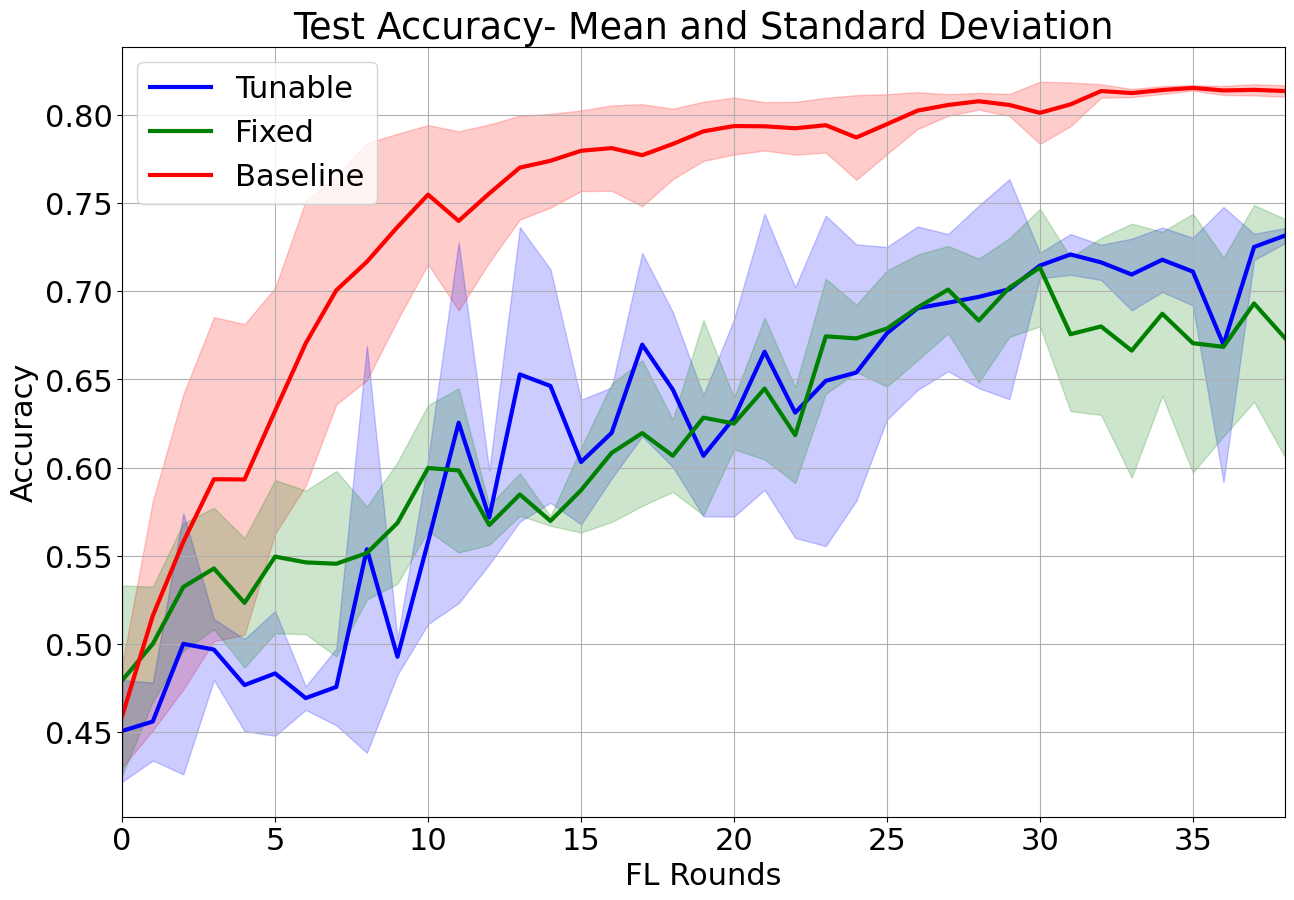

In [16]:
plot_accuracy(
    tunable_mean_test_accuracy,
    tunable_std_test_accuracy,
    fixed_mean_test_accuracy,
    fixed_std_test_accuracy,
    baseline_mean_test_accuracy,
    baseline_std_test_accuracy,
    experiment_type="Test",
)

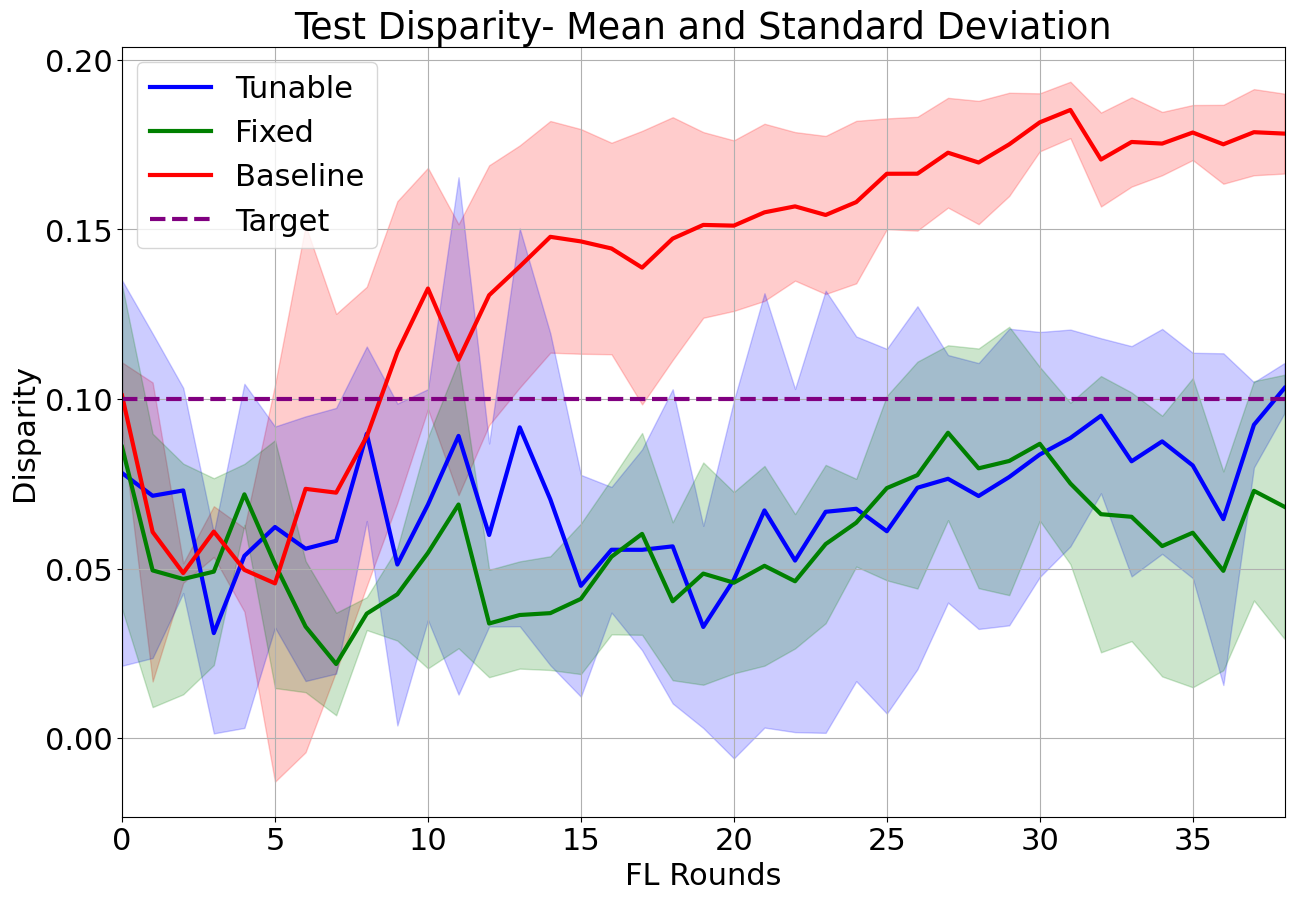

In [17]:
plot_disparity(
    tunable_mean_test_disparity,
    tunable_std_test_disparity,
    fixed_mean_test_disparity,
    fixed_std_test_disparity,
    baseline_mean_test_disparity,
    baseline_std_test_disparity,
    experiment_type="Test",
)

## 0.08 

### Pareto Frontier

In [18]:
tunable_data, fixed_data = load_pareto_data("dutch_008", 4)
new_list_tunable = prepare_data(tunable_data, max_lenght=25)
mean_df_tunable = create_avg_dataset(new_list_tunable)

In [19]:
new_list_fixed = prepare_data(fixed_data, max_lenght=25)
# new_list_fixed[3] = new_list_fixed[3][:30]
mean_df_fixed = create_avg_dataset(new_list_fixed)

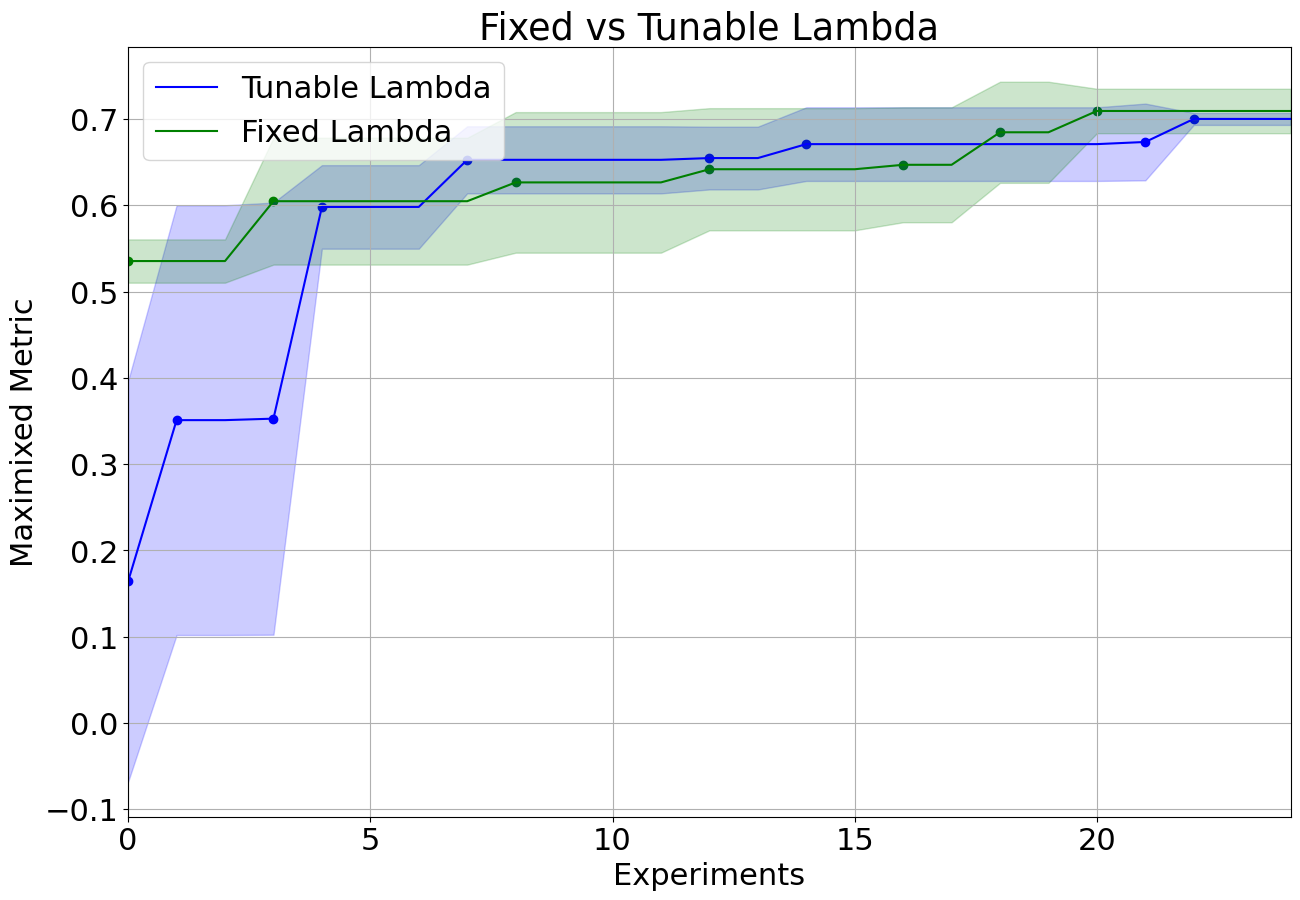

In [20]:
plot_pareto_frontier(mean_df_tunable, mean_df_fixed)

### Training and Test accuracy/disparity

In [4]:
tunable_links = [
    "/lucacorbucci/FL_PUF_Sweep/runs/xuf2f2uk",
    "/lucacorbucci/FL_PUF_Sweep/runs/uuexdrd2",
    "/lucacorbucci/FL_PUF_Sweep/runs/b2p3k8w3",
    # "/lucacorbucci/FL_PUF_Sweep/runs/mz3flegg",
    # "/lucacorbucci/FL_PUF_Sweep/runs/z7jrp3k9",
    # "/lucacorbucci/FL_PUF_Sweep/runs/0xfozoth",
    # "/lucacorbucci/FL_PUF_Sweep/runs/njp3n3mq",
    # "/lucacorbucci/FL_PUF_Sweep/runs/cbgr0zul",
    # "/lucacorbucci/FL_PUF_Sweep/runs/d65epyt1",
]
fixed_links = [
    "/lucacorbucci/FL_PUF_Sweep/runs/5y17ntcz",
    "/lucacorbucci/FL_PUF_Sweep/runs/x92r59wf",
    "/lucacorbucci/FL_PUF_Sweep/runs/231x5te5",
    # "/lucacorbucci/FL_PUF_Sweep/runs/6v76gh5f",
    # "/lucacorbucci/FL_PUF_Sweep/runs/alq0t0b4",
    # "/lucacorbucci/FL_PUF_Sweep/runs/rkn3aiq8",
    # "/lucacorbucci/FL_PUF_Sweep/runs/5bupft66",
    # "/lucacorbucci/FL_PUF_Sweep/runs/7ledzo4i",
    # "/lucacorbucci/FL_PUF_Sweep/runs/8ucmq64e",
]

baseline_links = [
    "/lucacorbucci/FL_PUF_Sweep/runs/lkdrj4ib",
    "/lucacorbucci/FL_PUF_Sweep/runs/8669og1q",
    "/lucacorbucci/FL_PUF_Sweep/runs/jsn812nl",
]

In [5]:
baseline_experiments, tunable_experiments, fixed_experiments = get_experiments(
    tunable_links, fixed_links, baseline_links
)

In [6]:
(
    baseline_mean_train_accuracy,
    baseline_mean_train_disparity,
    baseline_std_train_accuracy,
    baseline_std_train_disparity,
    fixed_mean_train_accuracy,
    fixed_mean_train_disparity,
    fixed_std_train_accuracy,
    fixed_std_train_disparity,
    tunable_mean_train_accuracy,
    tunable_mean_train_disparity,
    tunable_std_train_accuracy,
    tunable_std_train_disparity,
) = prepare_mean_and_std(
    tunable_experiments,
    fixed_experiments,
    baseline_experiments,
    accuracy_experiments_type="Train Accuracy",
    disparity_experiments_type="Training Disparity with statistics no noise",
)

39
39
39


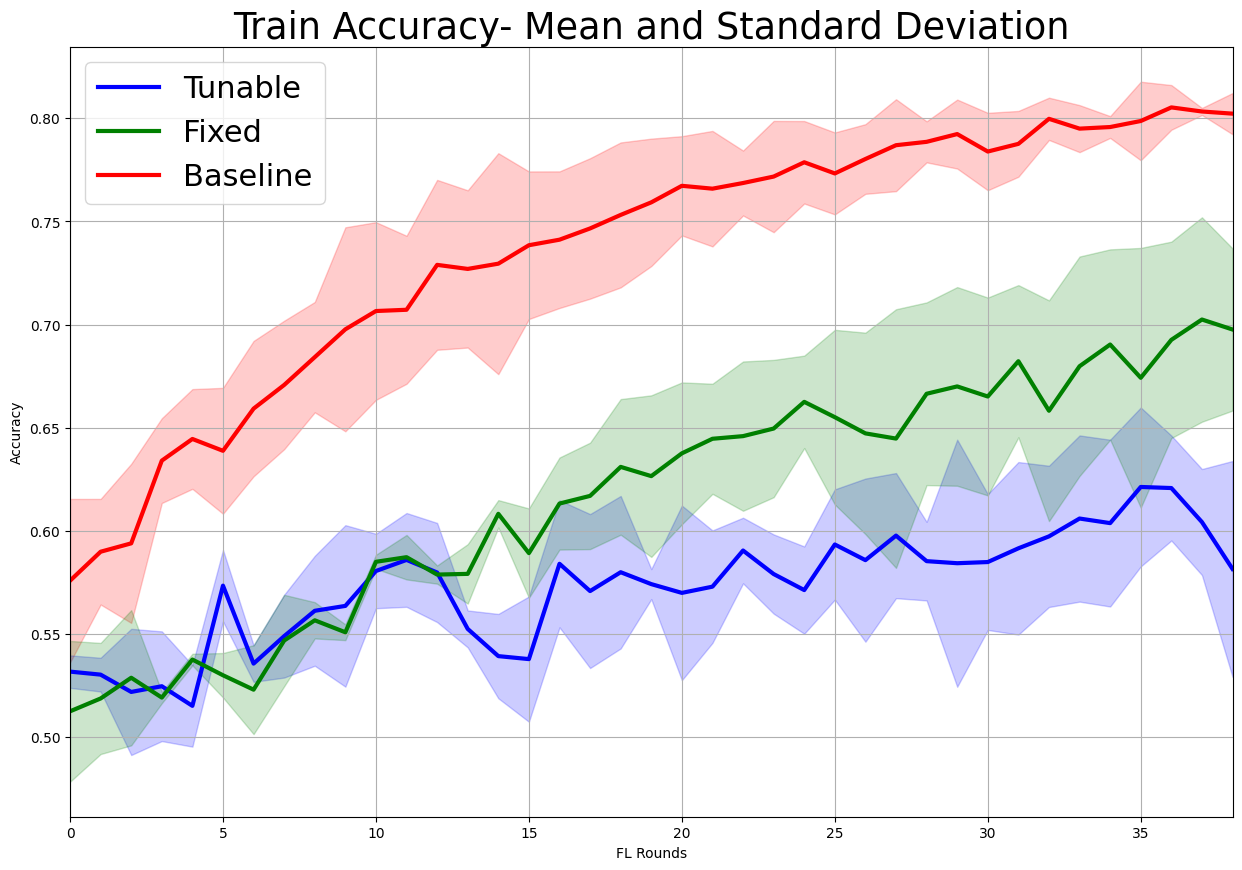

In [7]:
plot_accuracy(
    tunable_mean_train_accuracy,
    tunable_std_train_accuracy,
    fixed_mean_train_accuracy,
    fixed_std_train_accuracy,
    baseline_mean_train_accuracy,
    baseline_std_train_accuracy,
    experiment_type="Train",
)

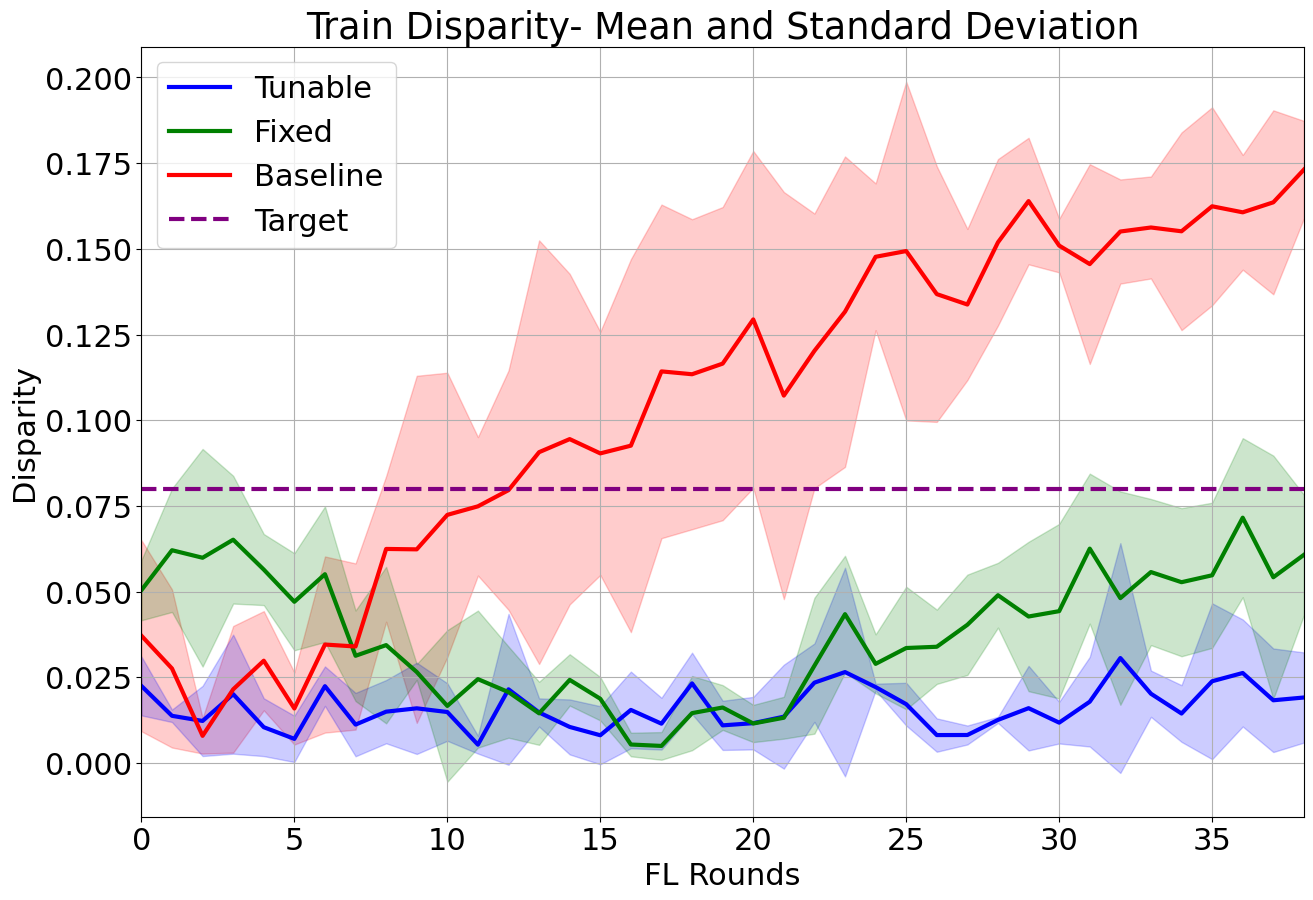

In [8]:
plot_disparity(
    tunable_mean_train_disparity,
    tunable_std_train_disparity,
    fixed_mean_train_disparity,
    fixed_std_train_disparity,
    baseline_mean_train_disparity,
    baseline_std_train_disparity,
    experiment_type="Train",
    target=0.08,
)

In [12]:
(
    baseline_mean_train_accuracy,
    baseline_mean_train_disparity,
    baseline_std_train_accuracy,
    baseline_std_train_disparity,
    fixed_mean_train_accuracy,
    fixed_mean_train_disparity,
    fixed_std_train_accuracy,
    fixed_std_train_disparity,
    tunable_mean_train_accuracy,
    tunable_mean_train_disparity,
    tunable_std_train_accuracy,
    tunable_std_train_disparity,
) = prepare_mean_and_std(
    tunable_experiments,
    fixed_experiments,
    baseline_experiments,
    accuracy_experiments_type="Validation_Accuracy",
    disparity_experiments_type="Validation Disparity with statistics",
)

39
39
39


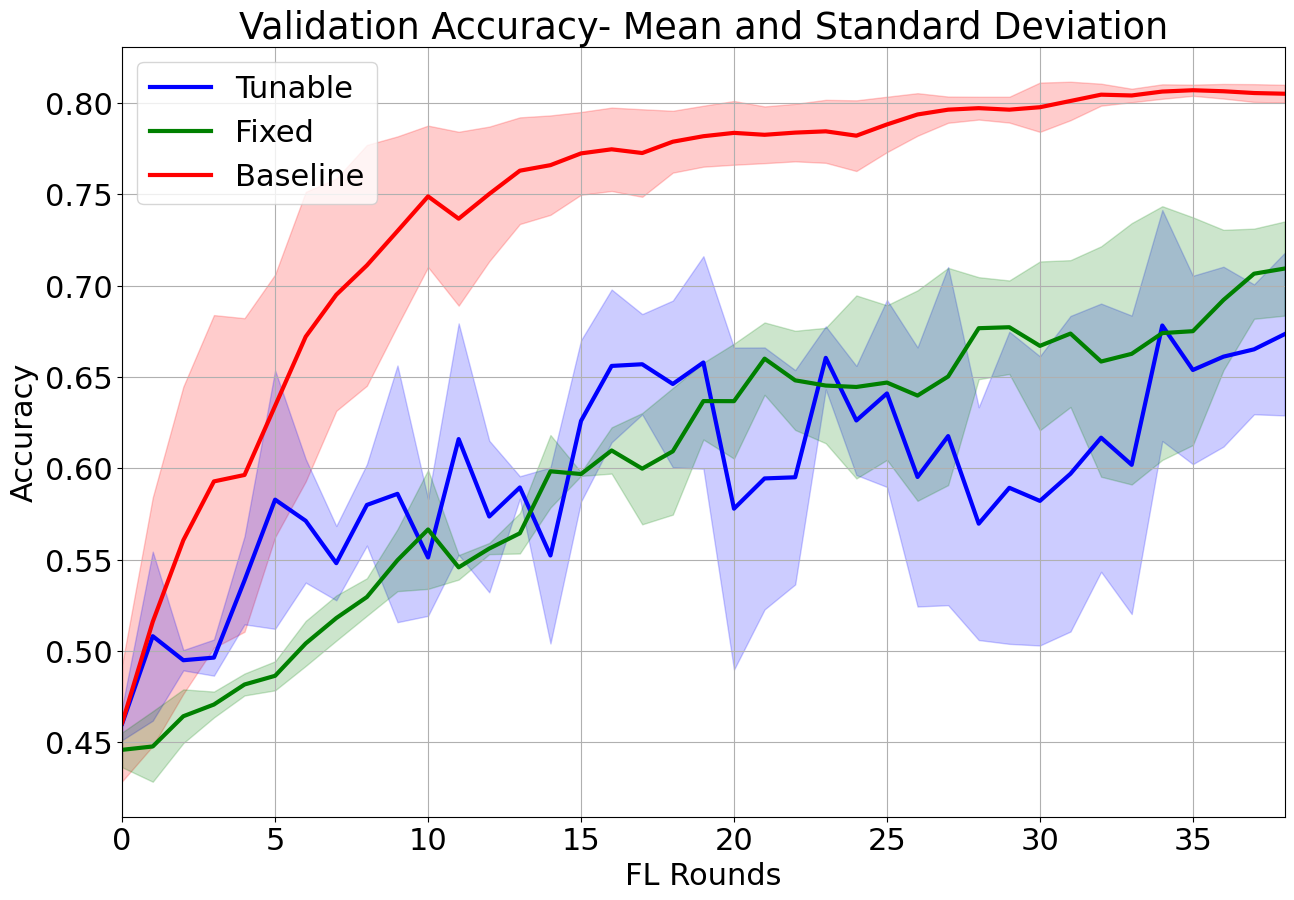

In [13]:
plot_accuracy(
    tunable_mean_train_accuracy,
    tunable_std_train_accuracy,
    fixed_mean_train_accuracy,
    fixed_std_train_accuracy,
    baseline_mean_train_accuracy,
    baseline_std_train_accuracy,
    experiment_type="Validation",
)

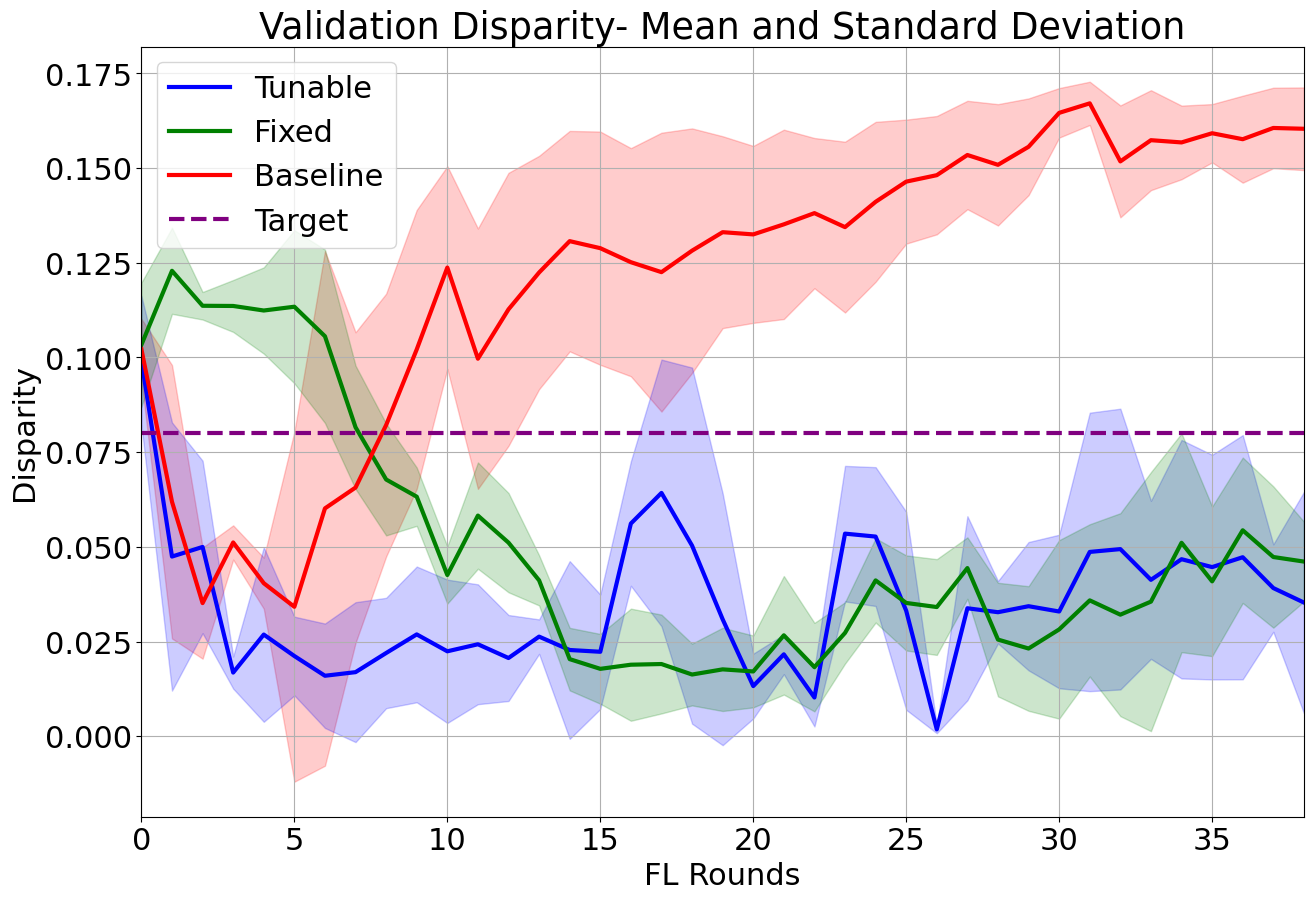

In [14]:
plot_disparity(
    tunable_mean_train_disparity,
    tunable_std_train_disparity,
    fixed_mean_train_disparity,
    fixed_std_train_disparity,
    baseline_mean_train_disparity,
    baseline_std_train_disparity,
    experiment_type="Validation",
    target=0.08,
)

In [15]:
(
    baseline_mean_test_accuracy,
    baseline_mean_test_disparity,
    baseline_std_test_accuracy,
    baseline_std_test_disparity,
    fixed_mean_test_accuracy,
    fixed_mean_test_disparity,
    fixed_std_test_accuracy,
    fixed_std_test_disparity,
    tunable_mean_test_accuracy,
    tunable_mean_test_disparity,
    tunable_std_test_accuracy,
    tunable_std_test_disparity,
) = prepare_mean_and_std(
    tunable_experiments,
    fixed_experiments,
    baseline_experiments,
    accuracy_experiments_type="Test Accuracy",
    disparity_experiments_type="Test Disparity with statistics",
)

39
39
39


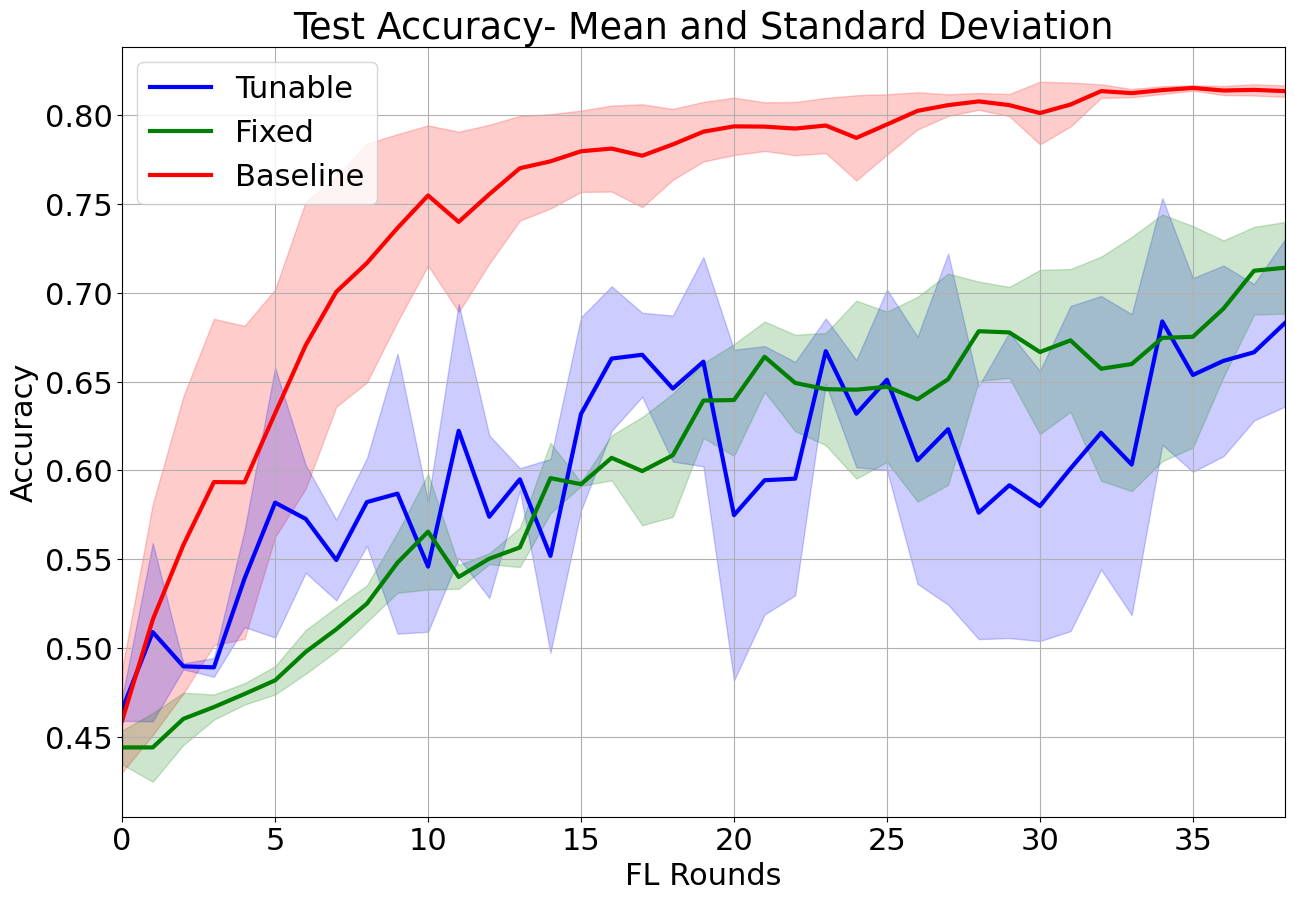

In [ ]:
plot_accuracy(
    tunable_mean_test_accuracy,
    tunable_std_test_accuracy,
    fixed_mean_test_accuracy,
    fixed_std_test_accuracy,
    baseline_mean_test_accuracy,
    baseline_std_test_accuracy,
    experiment_type="Test",
)

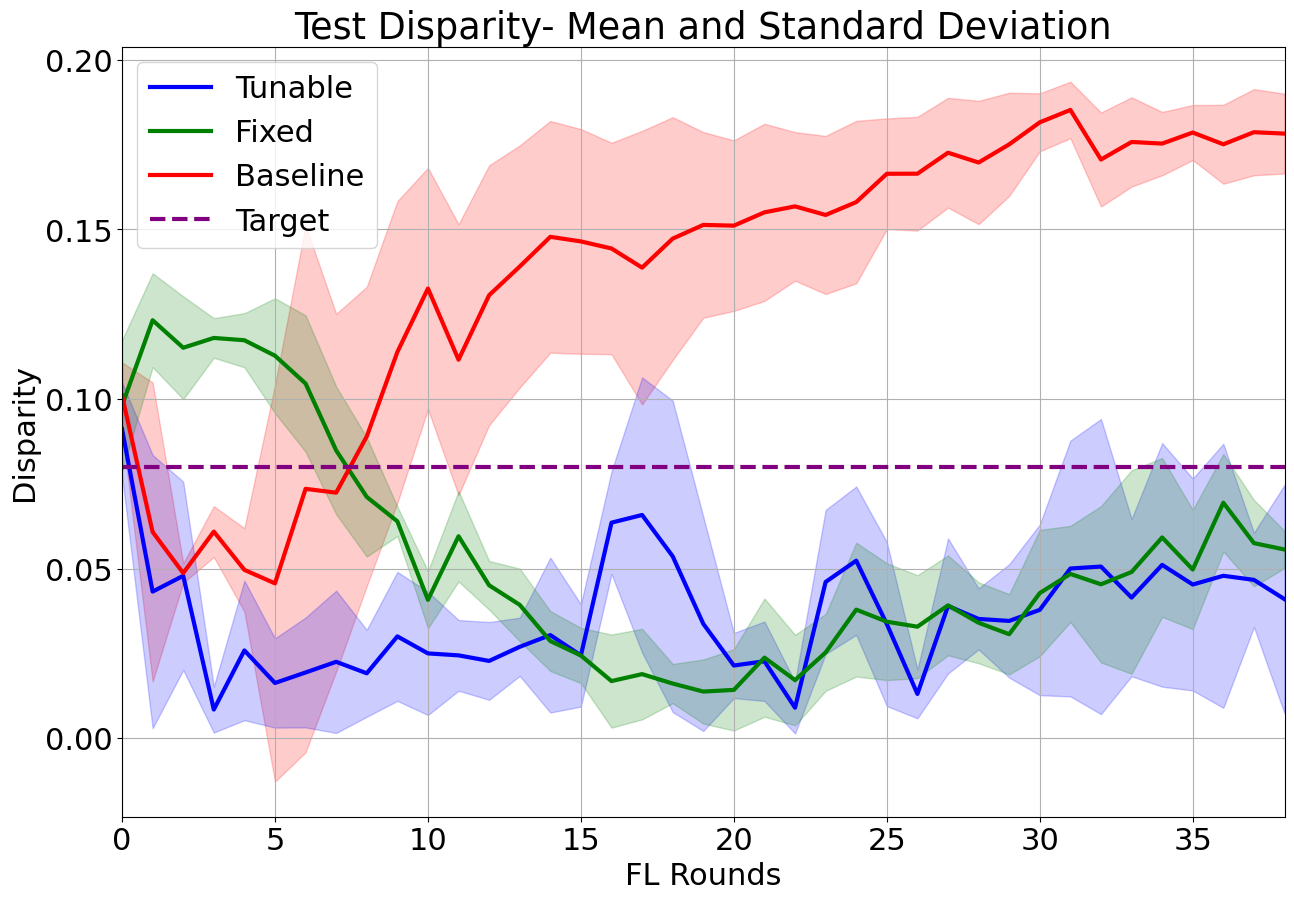

In [16]:
plot_disparity(
    tunable_mean_test_disparity,
    tunable_std_test_disparity,
    fixed_mean_test_disparity,
    fixed_std_test_disparity,
    baseline_mean_test_disparity,
    baseline_std_test_disparity,
    experiment_type="Test",
    target=0.08,
)

## 0.05

### Pareto Frontier

In [ ]:
tunable_data, fixed_data = load_pareto_data("dutch_005", 4)
new_list_tunable = prepare_data(tunable_data, max_lenght=25)
mean_df_tunable = create_avg_dataset(new_list_tunable)

In [ ]:
new_list_fixed = prepare_data(fixed_data, max_lenght=25)
# new_list_fixed[3] = new_list_fixed[3][:30]
mean_df_fixed = create_avg_dataset(new_list_fixed)

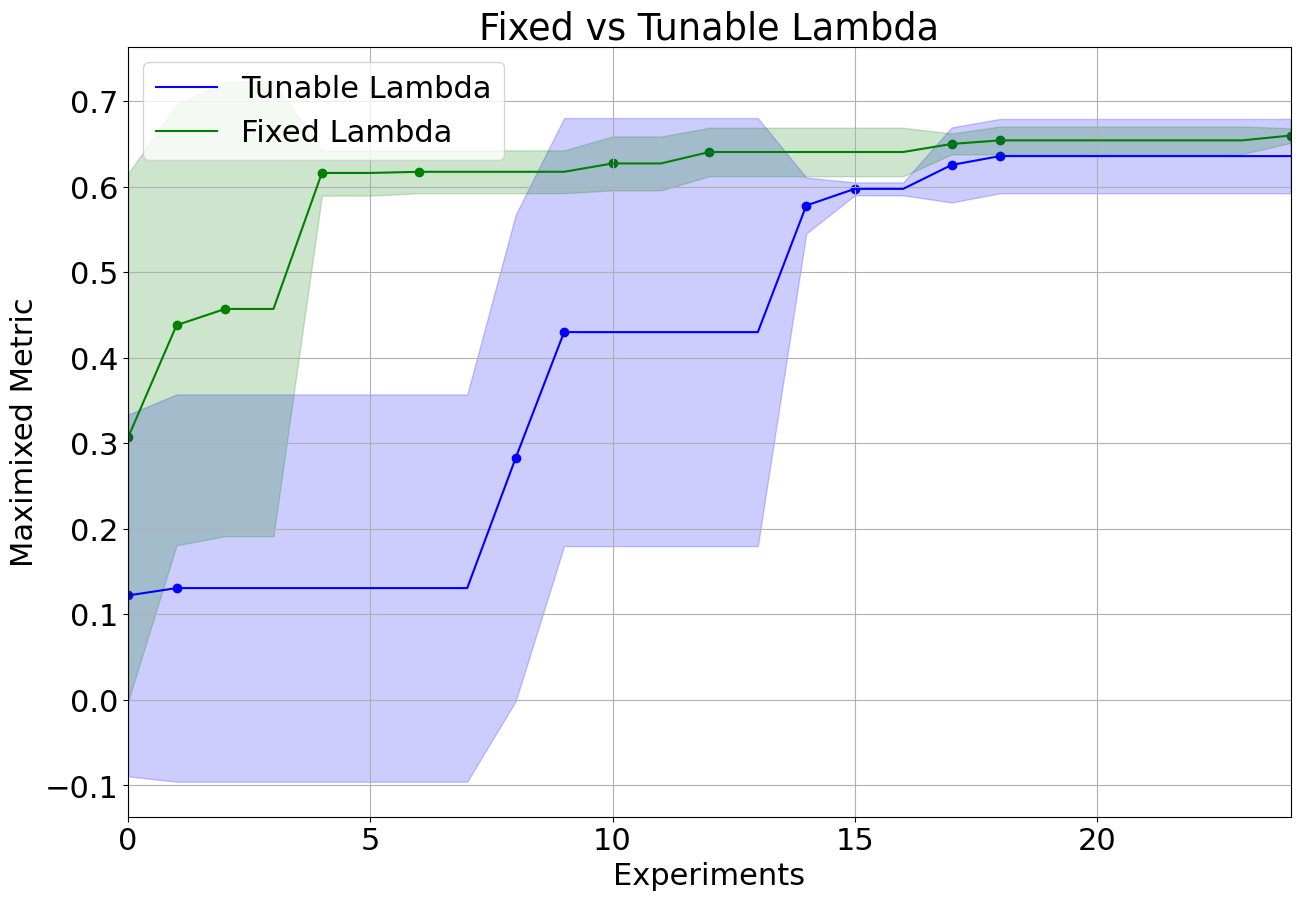

In [ ]:
plot_pareto_frontier(mean_df_tunable, mean_df_fixed)

### Training and Test accuracy/disparity

In [17]:
tunable_links = [
    "/lucacorbucci/FL_PUF_Sweep/runs/7yrzd0zm",
    # "/lucacorbucci/FL_PUF_Sweep/runs/fy8yontq",
    "/lucacorbucci/FL_PUF_Sweep/runs/fa7uxt1u",
    "/lucacorbucci/FL_PUF_Sweep/runs/3c2tworg",
    # "/lucacorbucci/FL_PUF_Sweep/runs/mz3flegg",
    # "/lucacorbucci/FL_PUF_Sweep/runs/z7jrp3k9",
    # "/lucacorbucci/FL_PUF_Sweep/runs/0xfozoth",
    # "/lucacorbucci/FL_PUF_Sweep/runs/njp3n3mq",
    # "/lucacorbucci/FL_PUF_Sweep/runs/cbgr0zul",
    # "/lucacorbucci/FL_PUF_Sweep/runs/d65epyt1",
]
fixed_links = [
    "/lucacorbucci/FL_PUF_Sweep/runs/1r1cmq6a",
    "/lucacorbucci/FL_PUF_Sweep/runs/1mub82y1",
    "/lucacorbucci/FL_PUF_Sweep/runs/bvxtqx0s",
    # "/lucacorbucci/FL_PUF_Sweep/runs/xp3qcna2",
    # "/lucacorbucci/FL_PUF_Sweep/runs/6v76gh5f",
    # "/lucacorbucci/FL_PUF_Sweep/runs/alq0t0b4",
    # "/lucacorbucci/FL_PUF_Sweep/runs/rkn3aiq8",
    # "/lucacorbucci/FL_PUF_Sweep/runs/5bupft66",
    # "/lucacorbucci/FL_PUF_Sweep/runs/7ledzo4i",
    # "/lucacorbucci/FL_PUF_Sweep/runs/8ucmq64e",
]

baseline_links = [
    "/lucacorbucci/FL_PUF_Sweep/runs/lkdrj4ib",
    "/lucacorbucci/FL_PUF_Sweep/runs/8669og1q",
    "/lucacorbucci/FL_PUF_Sweep/runs/jsn812nl",
]

In [18]:
baseline_experiments, tunable_experiments, fixed_experiments = get_experiments(
    tunable_links, fixed_links, baseline_links
)

In [19]:
(
    baseline_mean_train_accuracy,
    baseline_mean_train_disparity,
    baseline_std_train_accuracy,
    baseline_std_train_disparity,
    fixed_mean_train_accuracy,
    fixed_mean_train_disparity,
    fixed_std_train_accuracy,
    fixed_std_train_disparity,
    tunable_mean_train_accuracy,
    tunable_mean_train_disparity,
    tunable_std_train_accuracy,
    tunable_std_train_disparity,
) = prepare_mean_and_std(
    tunable_experiments,
    fixed_experiments,
    baseline_experiments,
    accuracy_experiments_type="Train Accuracy",
    disparity_experiments_type="Training Disparity with statistics no noise",
)

39
39
39


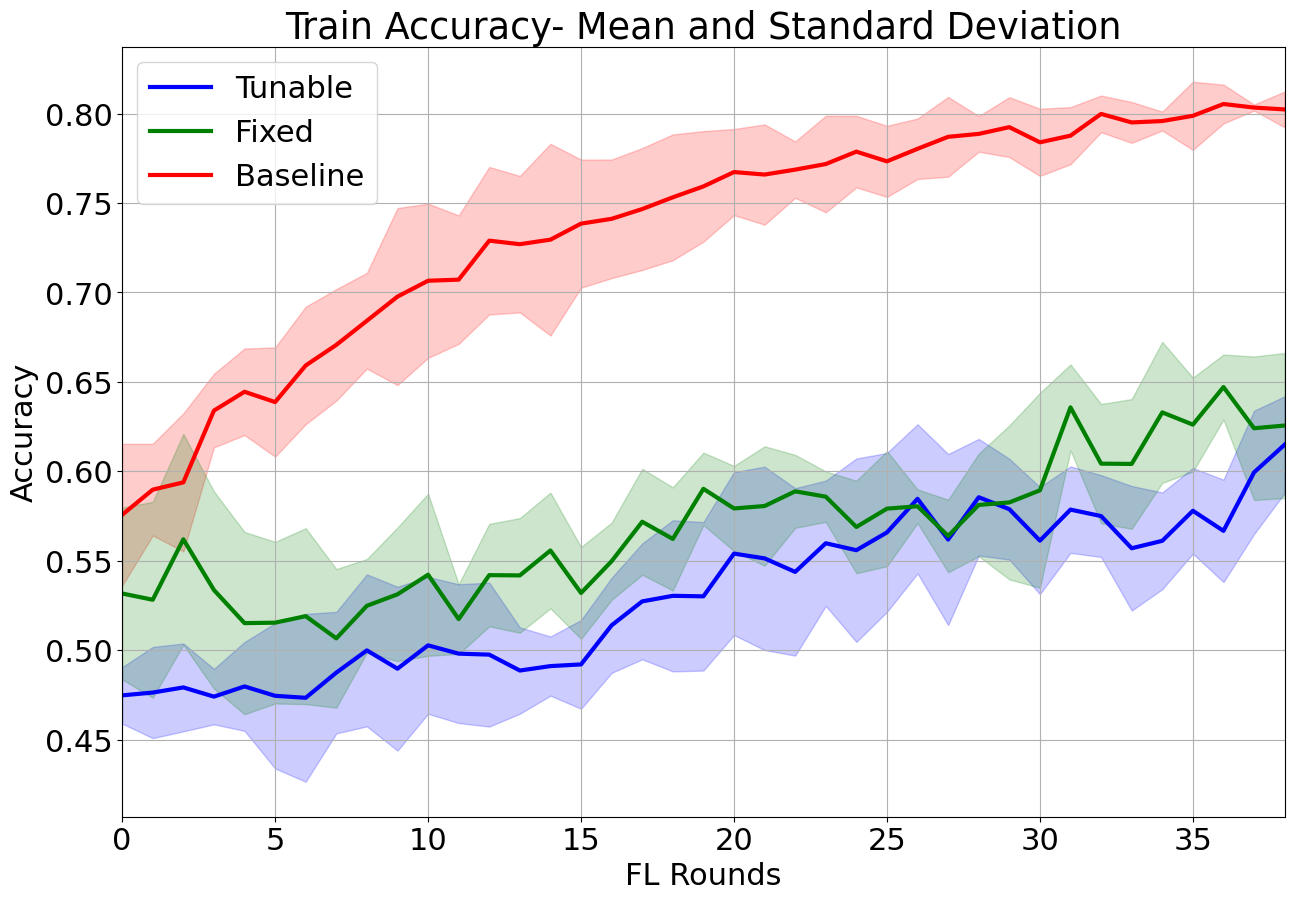

In [ ]:
plot_accuracy(
    tunable_mean_train_accuracy,
    tunable_std_train_accuracy,
    fixed_mean_train_accuracy,
    fixed_std_train_accuracy,
    baseline_mean_train_accuracy,
    baseline_std_train_accuracy,
    experiment_type="Train",
)

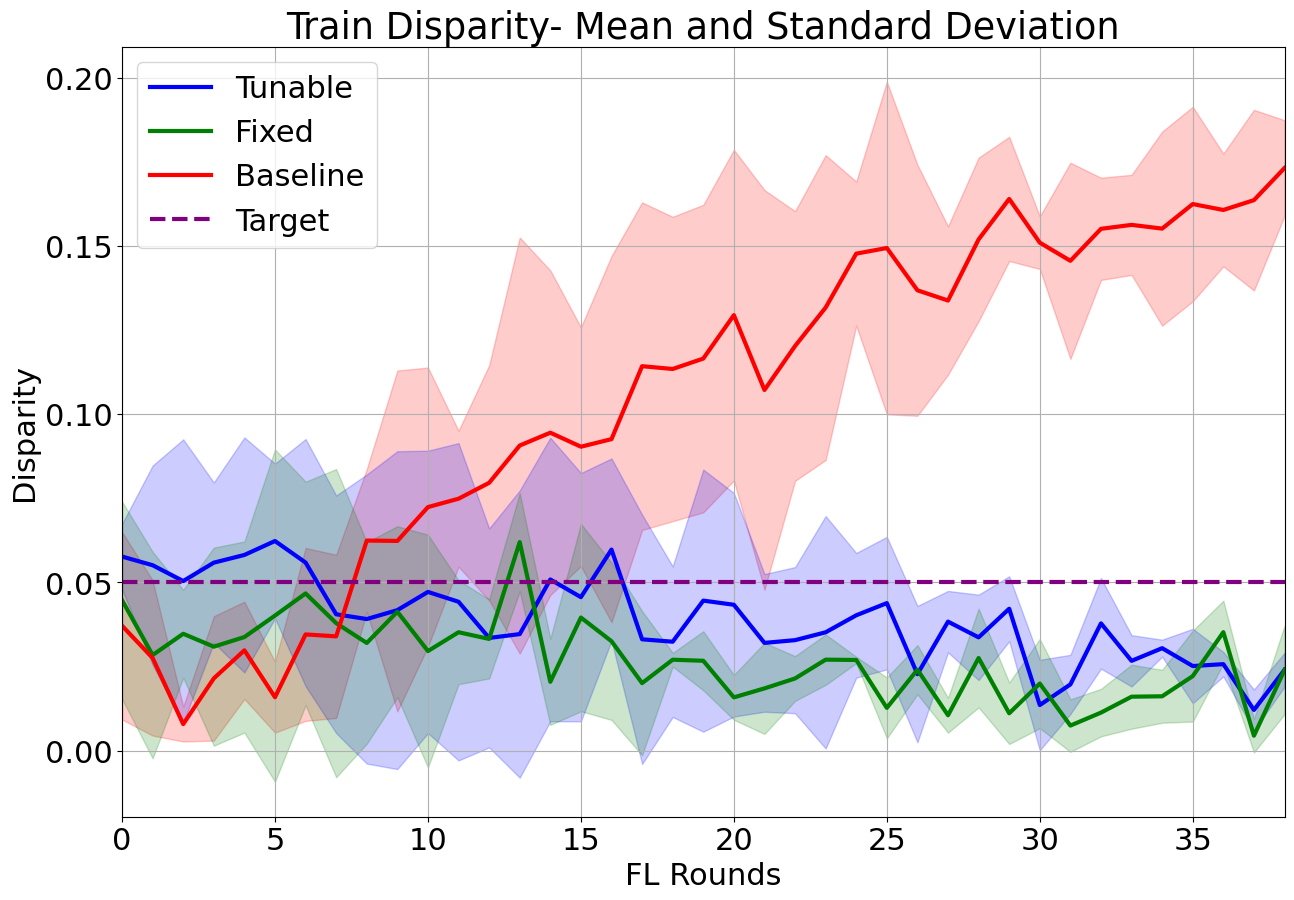

In [20]:
plot_disparity(
    tunable_mean_train_disparity,
    tunable_std_train_disparity,
    fixed_mean_train_disparity,
    fixed_std_train_disparity,
    baseline_mean_train_disparity,
    baseline_std_train_disparity,
    experiment_type="Train",
    target=0.05,
)

In [21]:
(
    baseline_mean_train_accuracy,
    baseline_mean_train_disparity,
    baseline_std_train_accuracy,
    baseline_std_train_disparity,
    fixed_mean_train_accuracy,
    fixed_mean_train_disparity,
    fixed_std_train_accuracy,
    fixed_std_train_disparity,
    tunable_mean_train_accuracy,
    tunable_mean_train_disparity,
    tunable_std_train_accuracy,
    tunable_std_train_disparity,
) = prepare_mean_and_std(
    tunable_experiments,
    fixed_experiments,
    baseline_experiments,
    accuracy_experiments_type="Validation_Accuracy",
    disparity_experiments_type="Validation Disparity with statistics",
)

39
39
39


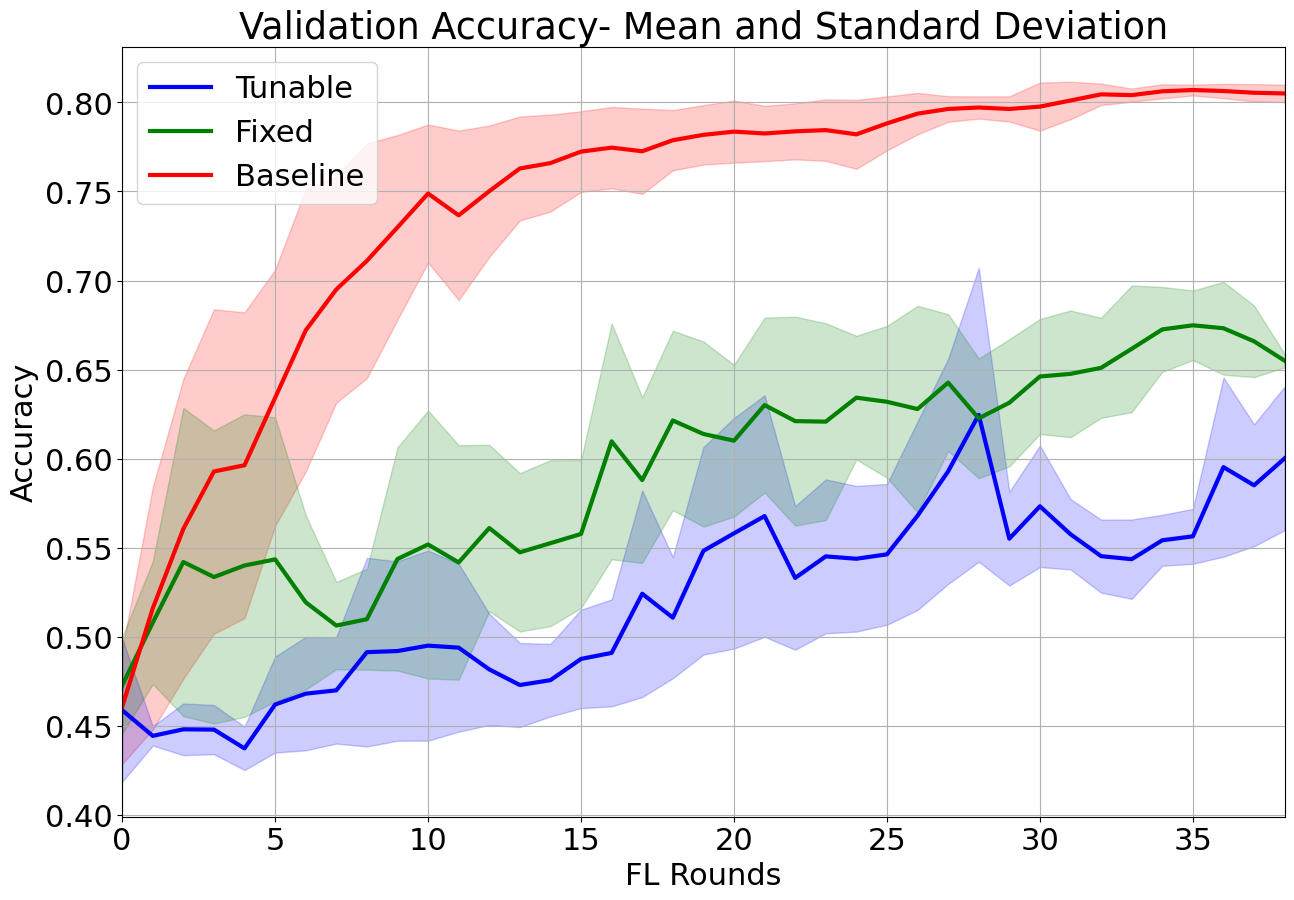

In [ ]:
plot_accuracy(
    tunable_mean_train_accuracy,
    tunable_std_train_accuracy,
    fixed_mean_train_accuracy,
    fixed_std_train_accuracy,
    baseline_mean_train_accuracy,
    baseline_std_train_accuracy,
    experiment_type="Validation",
)

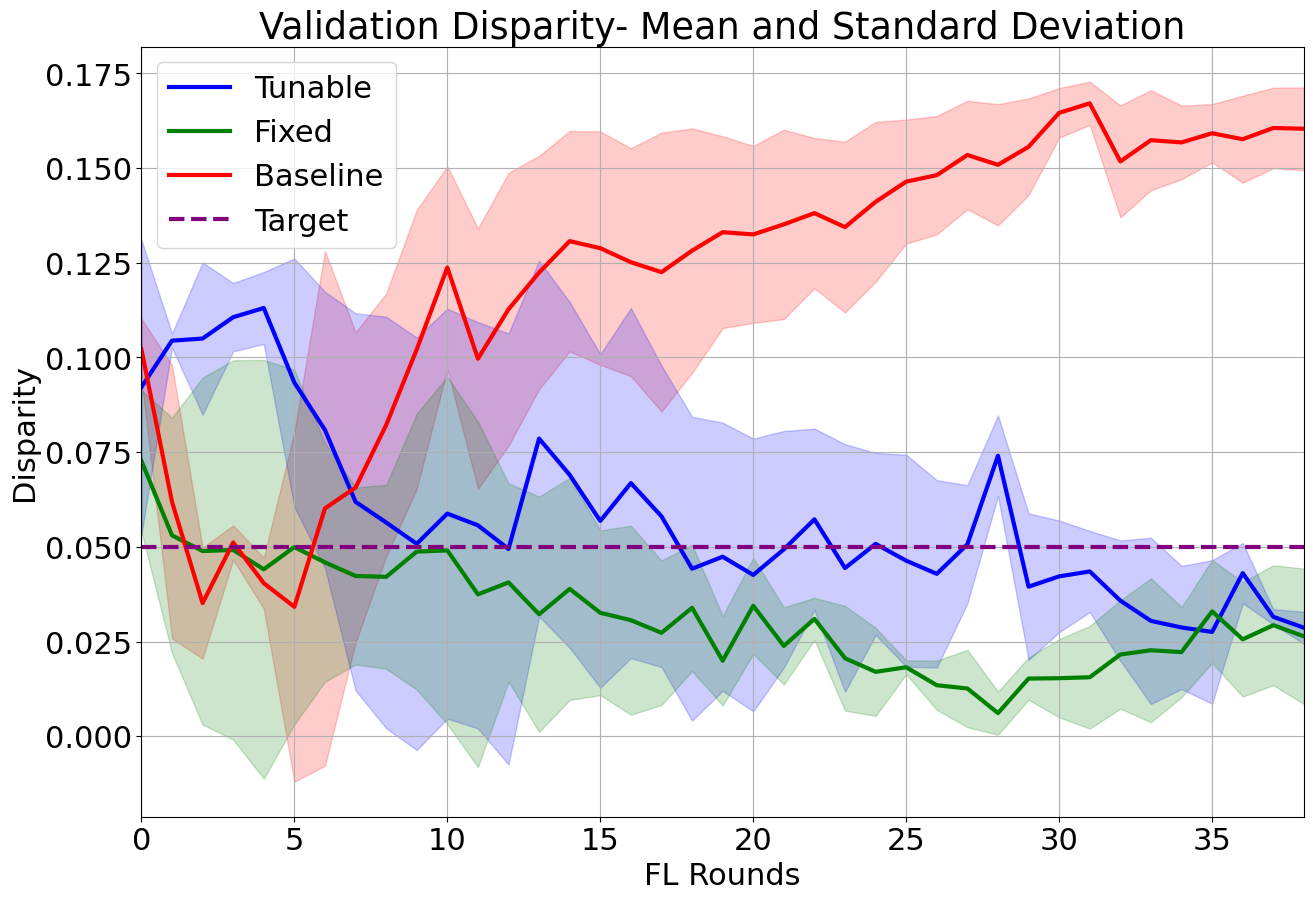

In [22]:
plot_disparity(
    tunable_mean_train_disparity,
    tunable_std_train_disparity,
    fixed_mean_train_disparity,
    fixed_std_train_disparity,
    baseline_mean_train_disparity,
    baseline_std_train_disparity,
    experiment_type="Validation",
    target=0.05,
)

In [23]:
(
    baseline_mean_test_accuracy,
    baseline_mean_test_disparity,
    baseline_std_test_accuracy,
    baseline_std_test_disparity,
    fixed_mean_test_accuracy,
    fixed_mean_test_disparity,
    fixed_std_test_accuracy,
    fixed_std_test_disparity,
    tunable_mean_test_accuracy,
    tunable_mean_test_disparity,
    tunable_std_test_accuracy,
    tunable_std_test_disparity,
) = prepare_mean_and_std(
    tunable_experiments,
    fixed_experiments,
    baseline_experiments,
    accuracy_experiments_type="Test Accuracy",
    disparity_experiments_type="Test Disparity with statistics",
)

39
39
39


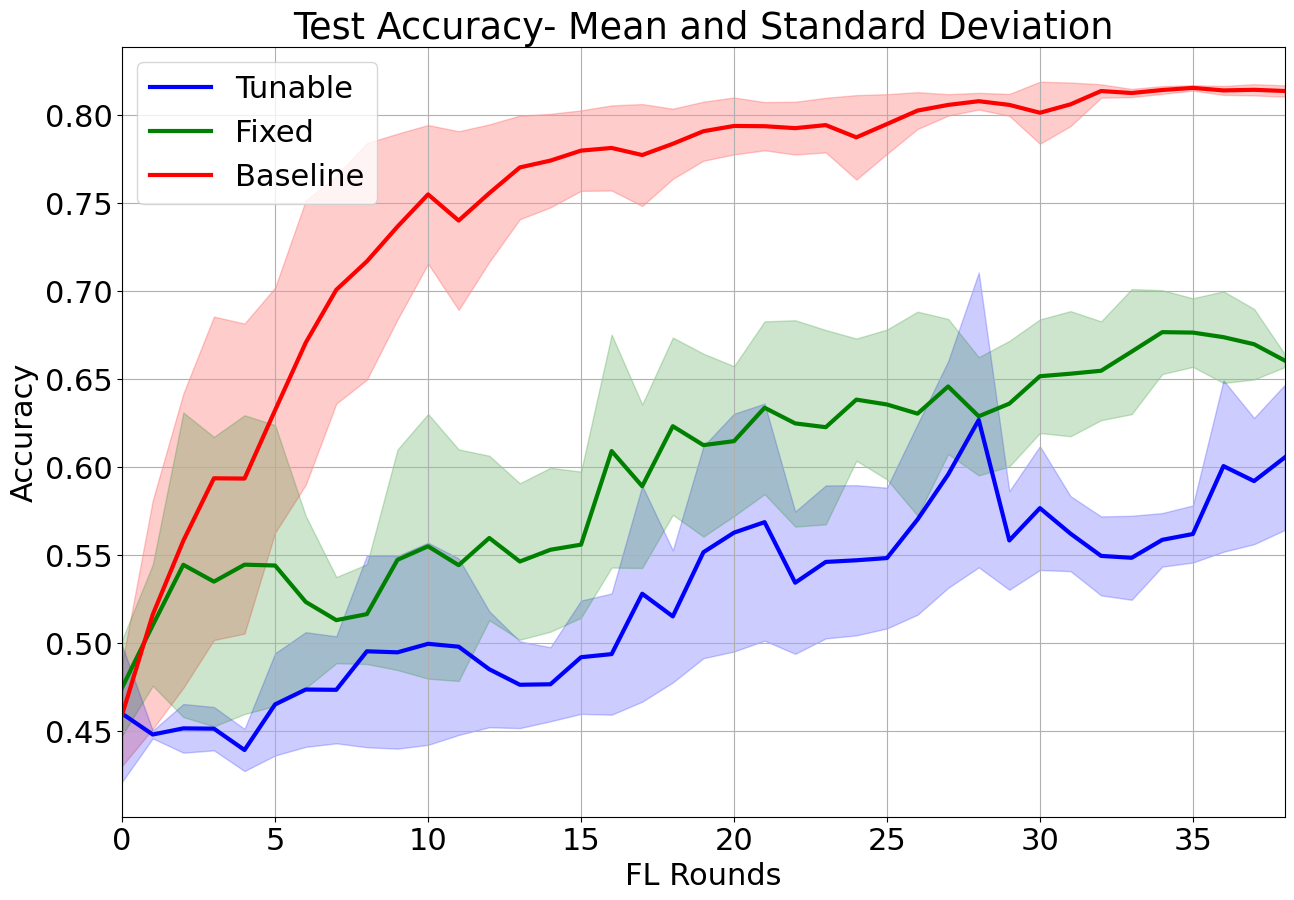

In [ ]:
plot_accuracy(
    tunable_mean_test_accuracy,
    tunable_std_test_accuracy,
    fixed_mean_test_accuracy,
    fixed_std_test_accuracy,
    baseline_mean_test_accuracy,
    baseline_std_test_accuracy,
    experiment_type="Test",
)

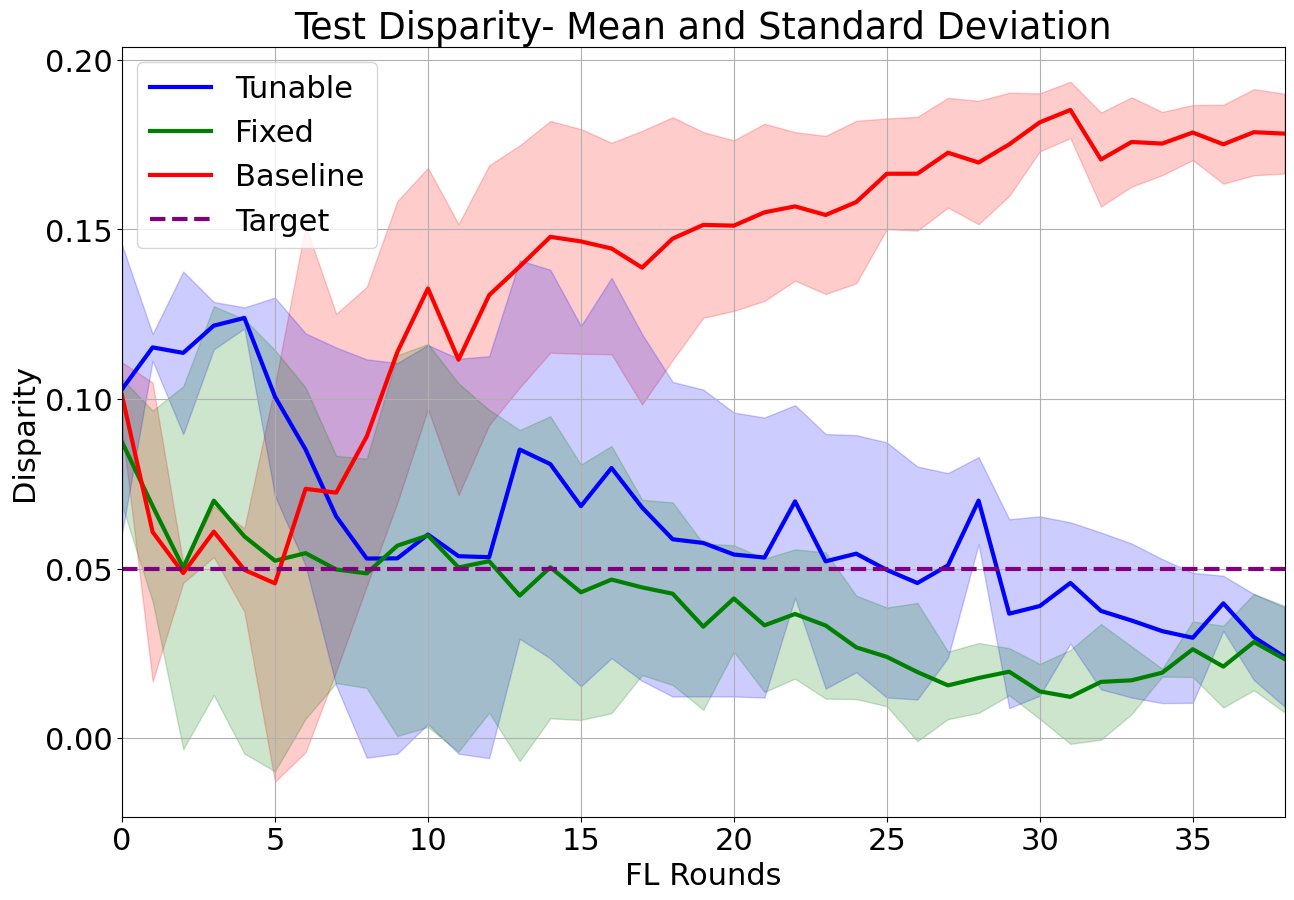

In [24]:
plot_disparity(
    tunable_mean_test_disparity,
    tunable_std_test_disparity,
    fixed_mean_test_disparity,
    fixed_std_test_disparity,
    baseline_mean_test_disparity,
    baseline_std_test_disparity,
    experiment_type="Test",
    target=0.05,
)

# Dutch Experiments

### Pareto Frontier

In [ ]:
tunable_data, fixed_data = load_pareto_data("dutch", 10)
new_list_tunable = prepare_data(tunable_data)
mean_df_tunable = create_avg_dataset(new_list_tunable)
new_list_fixed = prepare_data(fixed_data)
mean_df_fixed = create_avg_dataset(new_list_fixed)

In [ ]:
plot_pareto_frontier(mean_df_tunable, mean_df_fixed)

### Training and Test accuracy/disparity

In [ ]:
tunable_links = [
    "/lucacorbucci/FL_PUF_Sweep/runs/mm9p806b",
    "/lucacorbucci/FL_PUF_Sweep/runs/0y8xvf3m",
    "/lucacorbucci/FL_PUF_Sweep/runs/y8mm9msa",
    "/lucacorbucci/FL_PUF_Sweep/runs/iisn3t04",
    "/lucacorbucci/FL_PUF_Sweep/runs/lfub0nl0",
    # "/lucacorbucci/FL_PUF_Sweep/runs/z7jrp3k9",
    # "/lucacorbucci/FL_PUF_Sweep/runs/0xfozoth",
    # "/lucacorbucci/FL_PUF_Sweep/runs/njp3n3mq",
    # "/lucacorbucci/FL_PUF_Sweep/runs/cbgr0zul",
    # "/lucacorbucci/FL_PUF_Sweep/runs/d65epyt1",
]
fixed_links = [
    "/lucacorbucci/FL_PUF_Sweep/runs/bypktt1o",
    "/lucacorbucci/FL_PUF_Sweep/runs/arykfyy9",
    "/lucacorbucci/FL_PUF_Sweep/runs/zc5m1w4z",
    "/lucacorbucci/FL_PUF_Sweep/runs/ees1cq8g",
    "/lucacorbucci/FL_PUF_Sweep/runs/9qwscioo",
    # "/lucacorbucci/FL_PUF_Sweep/runs/alq0t0b4",
    # "/lucacorbucci/FL_PUF_Sweep/runs/rkn3aiq8",
    # "/lucacorbucci/FL_PUF_Sweep/runs/5bupft66",
    # "/lucacorbucci/FL_PUF_Sweep/runs/7ledzo4i",
    # "/lucacorbucci/FL_PUF_Sweep/runs/8ucmq64e",
]

baseline_links = ["/lucacorbucci/FL_PUF_Sweep/runs/j7vkw1ho"]

In [ ]:
baseline_experiments, tunable_experiments, fixed_experiments = get_experiments(
    tunable_links, fixed_links, baseline_links
)

In [ ]:
(
    baseline_mean_train_accuracy,
    baseline_mean_train_disparity,
    baseline_std_train_accuracy,
    baseline_std_train_disparity,
    fixed_mean_train_accuracy,
    fixed_mean_train_disparity,
    fixed_std_train_accuracy,
    fixed_std_train_disparity,
    tunable_mean_train_accuracy,
    tunable_mean_train_disparity,
    tunable_std_train_accuracy,
    tunable_std_train_disparity,
) = prepare_mean_and_std(
    tunable_experiments,
    fixed_experiments,
    baseline_experiments,
    accuracy_experiments_type="Train Accuracy",
    disparity_experiments_type="Training Disparity with statistics no noise",
)

In [ ]:
plot_accuracy(
    tunable_mean_train_accuracy,
    tunable_std_train_accuracy,
    fixed_mean_train_accuracy,
    fixed_std_train_accuracy,
    baseline_mean_train_accuracy,
    baseline_std_train_accuracy,
    experiment_type="Train",
)

In [ ]:
plot_disparity(
    tunable_mean_train_disparity,
    tunable_std_train_disparity,
    fixed_mean_train_disparity,
    fixed_std_train_disparity,
    baseline_mean_train_disparity,
    baseline_std_train_disparity,
    experiment_type="Train",
)

In [ ]:
(
    baseline_mean_test_accuracy,
    baseline_mean_test_disparity,
    baseline_std_test_accuracy,
    baseline_std_test_disparity,
    fixed_mean_test_accuracy,
    fixed_mean_test_disparity,
    fixed_std_test_accuracy,
    fixed_std_test_disparity,
    tunable_mean_test_accuracy,
    tunable_mean_test_disparity,
    tunable_std_test_accuracy,
    tunable_std_test_disparity,
) = prepare_mean_and_std(
    tunable_experiments,
    fixed_experiments,
    baseline_experiments,
    accuracy_experiments_type="Validation_Accuracy",
    disparity_experiments_type="Validation Disparity with statistics",
)

In [ ]:
plot_accuracy(
    tunable_mean_test_accuracy,
    tunable_std_test_accuracy,
    fixed_mean_test_accuracy,
    fixed_std_test_accuracy,
    baseline_mean_test_accuracy,
    baseline_std_test_accuracy,
    experiment_type="Validation",
)

In [ ]:
plot_disparity(
    tunable_mean_test_disparity,
    tunable_std_test_disparity,
    fixed_mean_test_disparity,
    fixed_std_test_disparity,
    baseline_mean_test_disparity,
    baseline_std_test_disparity,
    experiment_type="Validation",
)

In [ ]:
(
    baseline_mean_test_accuracy,
    baseline_mean_test_disparity,
    baseline_std_test_accuracy,
    baseline_std_test_disparity,
    fixed_mean_test_accuracy,
    fixed_mean_test_disparity,
    fixed_std_test_accuracy,
    fixed_std_test_disparity,
    tunable_mean_test_accuracy,
    tunable_mean_test_disparity,
    tunable_std_test_accuracy,
    tunable_std_test_disparity,
) = prepare_mean_and_std(
    tunable_experiments,
    fixed_experiments,
    baseline_experiments,
    accuracy_experiments_type="Test Accuracy",
    disparity_experiments_type="Test Disparity with statistics",
)

In [ ]:
plot_accuracy(
    tunable_mean_test_accuracy,
    tunable_std_test_accuracy,
    fixed_mean_test_accuracy,
    fixed_std_test_accuracy,
    baseline_mean_test_accuracy,
    baseline_std_test_accuracy,
    experiment_type="Test",
)

In [ ]:
plot_disparity(
    tunable_mean_test_disparity,
    tunable_std_test_disparity,
    fixed_mean_test_disparity,
    fixed_std_test_disparity,
    baseline_mean_test_disparity,
    baseline_std_test_disparity,
    experiment_type="Test",
)

# Dutch Experiments Delta = -inf and Delta=-distance

### Pareto Frontier

In [ ]:
tunable_data, fixed_data = load_pareto_data("dutch_distance", 10)
new_list_tunable = prepare_data(tunable_data)

In [ ]:
len(new_list_tunable[2])

In [ ]:
mean_df_tunable = create_avg_dataset(new_list_tunable)
new_list_fixed = prepare_data(fixed_data)
mean_df_fixed = create_avg_dataset(new_list_fixed)

### Pareto Frontier

In [ ]:
tunable_data, fixed_data = load_pareto_data("dutch_distance", 10)
new_list_tunable = prepare_data(tunable_data)

In [ ]:
len(new_list_tunable[2])

In [ ]:
mean_df_tunable = create_avg_dataset(new_list_tunable)
new_list_fixed = prepare_data(fixed_data)
mean_df_fixed = create_avg_dataset(new_list_fixed)

In [ ]:
plot_pareto_frontier(mean_df_tunable, mean_df_fixed)

### Training and Test accuracy/disparity

In [ ]:
tunable_links = [
    "/lucacorbucci/FL_PUF_Sweep/runs/gaxlwz91",
    "/lucacorbucci/FL_PUF_Sweep/runs/o4ifjthe",
    "/lucacorbucci/FL_PUF_Sweep/runs/2yvk56zk",
    "/lucacorbucci/FL_PUF_Sweep/runs/cuks3grs",
    "/lucacorbucci/FL_PUF_Sweep/runs/jaqjbe27",
    # "/lucacorbucci/FL_PUF_Sweep/runs/z7jrp3k9",
    # "/lucacorbucci/FL_PUF_Sweep/runs/0xfozoth",
    # "/lucacorbucci/FL_PUF_Sweep/runs/njp3n3mq",
    # "/lucacorbucci/FL_PUF_Sweep/runs/cbgr0zul",
    # "/lucacorbucci/FL_PUF_Sweep/runs/d65epyt1",
]
fixed_links = [
    "/lucacorbucci/FL_PUF_Sweep/runs/naso97n1",
    "/lucacorbucci/FL_PUF_Sweep/runs/7wz4cakn",
    "/lucacorbucci/FL_PUF_Sweep/runs/pxxl3ss8",
    # "/lucacorbucci/FL_PUF_Sweep/runs/ees1cq8g",
    # "/lucacorbucci/FL_PUF_Sweep/runs/9qwscioo",
    # "/lucacorbucci/FL_PUF_Sweep/runs/alq0t0b4",
    # "/lucacorbucci/FL_PUF_Sweep/runs/rkn3aiq8",
    # "/lucacorbucci/FL_PUF_Sweep/runs/5bupft66",
    # "/lucacorbucci/FL_PUF_Sweep/runs/7ledzo4i",
    # "/lucacorbucci/FL_PUF_Sweep/runs/8ucmq64e",
]

baseline_links = [
    "/lucacorbucci/FL_PUF_Sweep/runs/p3gneeq1",
    "/lucacorbucci/FL_PUF_Sweep/runs/z3myh5h1",
    "/lucacorbucci/FL_PUF_Sweep/runs/4gwxym8q",
    "/lucacorbucci/FL_PUF_Sweep/runs/vupcha1q",
    "/lucacorbucci/FL_PUF_Sweep/runs/2ztj0x1f",
]

In [ ]:
baseline_experiments, tunable_experiments, fixed_experiments = get_experiments(
    tunable_links, fixed_links, baseline_links
)

In [ ]:
(
    baseline_mean_train_accuracy,
    baseline_mean_train_disparity,
    baseline_std_train_accuracy,
    baseline_std_train_disparity,
    fixed_mean_train_accuracy,
    fixed_mean_train_disparity,
    fixed_std_train_accuracy,
    fixed_std_train_disparity,
    tunable_mean_train_accuracy,
    tunable_mean_train_disparity,
    tunable_std_train_accuracy,
    tunable_std_train_disparity,
) = prepare_mean_and_std(
    tunable_experiments,
    fixed_experiments,
    baseline_experiments,
    accuracy_experiments_type="Train Accuracy",
    disparity_experiments_type="Training Disparity with statistics no noise",
)

In [ ]:
plot_accuracy(
    tunable_mean_train_accuracy,
    tunable_std_train_accuracy,
    fixed_mean_train_accuracy,
    fixed_std_train_accuracy,
    baseline_mean_train_accuracy,
    baseline_std_train_accuracy,
    experiment_type="Train",
)

In [ ]:
plot_disparity(
    tunable_mean_train_disparity,
    tunable_std_train_disparity,
    fixed_mean_train_disparity,
    fixed_std_train_disparity,
    baseline_mean_train_disparity,
    baseline_std_train_disparity,
    experiment_type="Train",
)

In [ ]:
(
    baseline_mean_train_accuracy,
    baseline_mean_train_disparity,
    baseline_std_train_accuracy,
    baseline_std_train_disparity,
    fixed_mean_train_accuracy,
    fixed_mean_train_disparity,
    fixed_std_train_accuracy,
    fixed_std_train_disparity,
    tunable_mean_train_accuracy,
    tunable_mean_train_disparity,
    tunable_std_train_accuracy,
    tunable_std_train_disparity,
) = prepare_mean_and_std(
    tunable_experiments,
    fixed_experiments,
    baseline_experiments,
    accuracy_experiments_type="Validation_Accuracy",
    disparity_experiments_type="Validation Disparity with statistics",
)

In [ ]:
plot_accuracy(
    tunable_mean_train_accuracy,
    tunable_std_train_accuracy,
    fixed_mean_train_accuracy,
    fixed_std_train_accuracy,
    baseline_mean_train_accuracy,
    baseline_std_train_accuracy,
    experiment_type="Validation",
)

In [ ]:
plot_disparity(
    tunable_mean_train_disparity,
    tunable_std_train_disparity,
    fixed_mean_train_disparity,
    fixed_std_train_disparity,
    baseline_mean_train_disparity,
    baseline_std_train_disparity,
    experiment_type="Validation",
)

In [ ]:
(
    baseline_mean_test_accuracy,
    baseline_mean_test_disparity,
    baseline_std_test_accuracy,
    baseline_std_test_disparity,
    fixed_mean_test_accuracy,
    fixed_mean_test_disparity,
    fixed_std_test_accuracy,
    fixed_std_test_disparity,
    tunable_mean_test_accuracy,
    tunable_mean_test_disparity,
    tunable_std_test_accuracy,
    tunable_std_test_disparity,
) = prepare_mean_and_std(
    tunable_experiments,
    fixed_experiments,
    baseline_experiments,
    accuracy_experiments_type="Test Accuracy",
    disparity_experiments_type="Test Disparity with statistics",
)

In [ ]:
plot_accuracy(
    tunable_mean_test_accuracy,
    tunable_std_test_accuracy,
    fixed_mean_test_accuracy,
    fixed_std_test_accuracy,
    baseline_mean_test_accuracy,
    baseline_std_test_accuracy,
    experiment_type="Test",
)

In [ ]:
plot_disparity(
    tunable_mean_test_disparity,
    tunable_std_test_disparity,
    fixed_mean_test_disparity,
    fixed_std_test_disparity,
    baseline_mean_test_disparity,
    baseline_std_test_disparity,
    experiment_type="Test",
)

In [ ]:
plot_pareto_frontier(mean_df_tunable, mean_df_fixed)

### Training and Test accuracy/disparity

In [ ]:
tunable_links = [
    "/lucacorbucci/FL_PUF_Sweep/runs/gaxlwz91",
    "/lucacorbucci/FL_PUF_Sweep/runs/o4ifjthe",
    "/lucacorbucci/FL_PUF_Sweep/runs/2yvk56zk",
    "/lucacorbucci/FL_PUF_Sweep/runs/cuks3grs",
    "/lucacorbucci/FL_PUF_Sweep/runs/jaqjbe27",
    # "/lucacorbucci/FL_PUF_Sweep/runs/z7jrp3k9",
    # "/lucacorbucci/FL_PUF_Sweep/runs/0xfozoth",
    # "/lucacorbucci/FL_PUF_Sweep/runs/njp3n3mq",
    # "/lucacorbucci/FL_PUF_Sweep/runs/cbgr0zul",
    # "/lucacorbucci/FL_PUF_Sweep/runs/d65epyt1",
]
fixed_links = [
    "/lucacorbucci/FL_PUF_Sweep/runs/naso97n1",
    "/lucacorbucci/FL_PUF_Sweep/runs/7wz4cakn",
    "/lucacorbucci/FL_PUF_Sweep/runs/pxxl3ss8",
    # "/lucacorbucci/FL_PUF_Sweep/runs/ees1cq8g",
    # "/lucacorbucci/FL_PUF_Sweep/runs/9qwscioo",
    # "/lucacorbucci/FL_PUF_Sweep/runs/alq0t0b4",
    # "/lucacorbucci/FL_PUF_Sweep/runs/rkn3aiq8",
    # "/lucacorbucci/FL_PUF_Sweep/runs/5bupft66",
    # "/lucacorbucci/FL_PUF_Sweep/runs/7ledzo4i",
    # "/lucacorbucci/FL_PUF_Sweep/runs/8ucmq64e",
]

baseline_links = [
    "/lucacorbucci/FL_PUF_Sweep/runs/p3gneeq1",
    "/lucacorbucci/FL_PUF_Sweep/runs/z3myh5h1",
    "/lucacorbucci/FL_PUF_Sweep/runs/4gwxym8q",
    "/lucacorbucci/FL_PUF_Sweep/runs/vupcha1q",
    "/lucacorbucci/FL_PUF_Sweep/runs/2ztj0x1f",
]

In [ ]:
baseline_experiments, tunable_experiments, fixed_experiments = get_experiments(
    tunable_links, fixed_links, baseline_links
)

In [ ]:
(
    baseline_mean_train_accuracy,
    baseline_mean_train_disparity,
    baseline_std_train_accuracy,
    baseline_std_train_disparity,
    fixed_mean_train_accuracy,
    fixed_mean_train_disparity,
    fixed_std_train_accuracy,
    fixed_std_train_disparity,
    tunable_mean_train_accuracy,
    tunable_mean_train_disparity,
    tunable_std_train_accuracy,
    tunable_std_train_disparity,
) = prepare_mean_and_std(
    tunable_experiments,
    fixed_experiments,
    baseline_experiments,
    accuracy_experiments_type="Train Accuracy",
    disparity_experiments_type="Training Disparity with statistics no noise",
)

In [ ]:
plot_accuracy(
    tunable_mean_train_accuracy,
    tunable_std_train_accuracy,
    fixed_mean_train_accuracy,
    fixed_std_train_accuracy,
    baseline_mean_train_accuracy,
    baseline_std_train_accuracy,
    experiment_type="Train",
)

In [ ]:
plot_disparity(
    tunable_mean_train_disparity,
    tunable_std_train_disparity,
    fixed_mean_train_disparity,
    fixed_std_train_disparity,
    baseline_mean_train_disparity,
    baseline_std_train_disparity,
    experiment_type="Train",
)

In [ ]:
(
    baseline_mean_train_accuracy,
    baseline_mean_train_disparity,
    baseline_std_train_accuracy,
    baseline_std_train_disparity,
    fixed_mean_train_accuracy,
    fixed_mean_train_disparity,
    fixed_std_train_accuracy,
    fixed_std_train_disparity,
    tunable_mean_train_accuracy,
    tunable_mean_train_disparity,
    tunable_std_train_accuracy,
    tunable_std_train_disparity,
) = prepare_mean_and_std(
    tunable_experiments,
    fixed_experiments,
    baseline_experiments,
    accuracy_experiments_type="Validation_Accuracy",
    disparity_experiments_type="Validation Disparity with statistics",
)

In [ ]:
plot_accuracy(
    tunable_mean_train_accuracy,
    tunable_std_train_accuracy,
    fixed_mean_train_accuracy,
    fixed_std_train_accuracy,
    baseline_mean_train_accuracy,
    baseline_std_train_accuracy,
    experiment_type="Validation",
)

In [ ]:
plot_disparity(
    tunable_mean_train_disparity,
    tunable_std_train_disparity,
    fixed_mean_train_disparity,
    fixed_std_train_disparity,
    baseline_mean_train_disparity,
    baseline_std_train_disparity,
    experiment_type="Validation",
)

In [ ]:
(
    baseline_mean_test_accuracy,
    baseline_mean_test_disparity,
    baseline_std_test_accuracy,
    baseline_std_test_disparity,
    fixed_mean_test_accuracy,
    fixed_mean_test_disparity,
    fixed_std_test_accuracy,
    fixed_std_test_disparity,
    tunable_mean_test_accuracy,
    tunable_mean_test_disparity,
    tunable_std_test_accuracy,
    tunable_std_test_disparity,
) = prepare_mean_and_std(
    tunable_experiments,
    fixed_experiments,
    baseline_experiments,
    accuracy_experiments_type="Test Accuracy",
    disparity_experiments_type="Test Disparity with statistics",
)

In [ ]:
plot_accuracy(
    tunable_mean_test_accuracy,
    tunable_std_test_accuracy,
    fixed_mean_test_accuracy,
    fixed_std_test_accuracy,
    baseline_mean_test_accuracy,
    baseline_std_test_accuracy,
    experiment_type="Test",
)

In [ ]:
plot_disparity(
    tunable_mean_test_disparity,
    tunable_std_test_disparity,
    fixed_mean_test_disparity,
    fixed_std_test_disparity,
    baseline_mean_test_disparity,
    baseline_std_test_disparity,
    experiment_type="Test",
)

# Dutch Experiments Delta = -inf and soft bound

### Pareto Frontier

In [ ]:
tunable_data, fixed_data = load_pareto_data("dutch_threshold", 10)
new_list_tunable = prepare_data(tunable_data)

In [ ]:
len(new_list_tunable[2])

In [ ]:
mean_df_tunable = create_avg_dataset(new_list_tunable)
new_list_fixed = prepare_data(fixed_data)
mean_df_fixed = create_avg_dataset(new_list_fixed)

In [ ]:
plot_pareto_frontier(mean_df_tunable, mean_df_fixed)

### Training and Test accuracy/disparity

In [ ]:
tunable_links = [
    "/lucacorbucci/FL_PUF_Sweep/runs/rjhh1wed",
    "/lucacorbucci/FL_PUF_Sweep/runs/osdrooo4",
    "/lucacorbucci/FL_PUF_Sweep/runs/jmrij8we",
    "/lucacorbucci/FL_PUF_Sweep/runs/7e29ahjw",
    "/lucacorbucci/FL_PUF_Sweep/runs/mz3flegg",
    # "/lucacorbucci/FL_PUF_Sweep/runs/z7jrp3k9",
    # "/lucacorbucci/FL_PUF_Sweep/runs/0xfozoth",
    # "/lucacorbucci/FL_PUF_Sweep/runs/njp3n3mq",
    # "/lucacorbucci/FL_PUF_Sweep/runs/cbgr0zul",
    # "/lucacorbucci/FL_PUF_Sweep/runs/d65epyt1",
]
fixed_links = [
    "/lucacorbucci/FL_PUF_Sweep/runs/x104bbth",
    "/lucacorbucci/FL_PUF_Sweep/runs/zibdfx7d",
    "/lucacorbucci/FL_PUF_Sweep/runs/5dsm3jg9",
    "/lucacorbucci/FL_PUF_Sweep/runs/qwf2ojbe",
    "/lucacorbucci/FL_PUF_Sweep/runs/6v76gh5f",
    # "/lucacorbucci/FL_PUF_Sweep/runs/alq0t0b4",
    # "/lucacorbucci/FL_PUF_Sweep/runs/rkn3aiq8",
    # "/lucacorbucci/FL_PUF_Sweep/runs/5bupft66",
    # "/lucacorbucci/FL_PUF_Sweep/runs/7ledzo4i",
    # "/lucacorbucci/FL_PUF_Sweep/runs/8ucmq64e",
]

baseline_links = [
    "/lucacorbucci/FL_PUF_Sweep/runs/y5ghikxf",
]

In [ ]:
baseline_experiments, tunable_experiments, fixed_experiments = get_experiments(
    tunable_links, fixed_links, baseline_links
)

In [ ]:
(
    baseline_mean_train_accuracy,
    baseline_mean_train_disparity,
    baseline_std_train_accuracy,
    baseline_std_train_disparity,
    fixed_mean_train_accuracy,
    fixed_mean_train_disparity,
    fixed_std_train_accuracy,
    fixed_std_train_disparity,
    tunable_mean_train_accuracy,
    tunable_mean_train_disparity,
    tunable_std_train_accuracy,
    tunable_std_train_disparity,
) = prepare_mean_and_std(
    tunable_experiments,
    fixed_experiments,
    baseline_experiments,
    accuracy_experiments_type="Train Accuracy",
    disparity_experiments_type="Training Disparity with statistics no noise",
)

In [ ]:
plot_accuracy(
    tunable_mean_train_accuracy,
    tunable_std_train_accuracy,
    fixed_mean_train_accuracy,
    fixed_std_train_accuracy,
    baseline_mean_train_accuracy,
    baseline_std_train_accuracy,
    experiment_type="Train",
)

In [ ]:
plot_disparity(
    tunable_mean_train_disparity,
    tunable_std_train_disparity,
    fixed_mean_train_disparity,
    fixed_std_train_disparity,
    baseline_mean_train_disparity,
    baseline_std_train_disparity,
    experiment_type="Train",
)

In [ ]:
(
    baseline_mean_train_accuracy,
    baseline_mean_train_disparity,
    baseline_std_train_accuracy,
    baseline_std_train_disparity,
    fixed_mean_train_accuracy,
    fixed_mean_train_disparity,
    fixed_std_train_accuracy,
    fixed_std_train_disparity,
    tunable_mean_train_accuracy,
    tunable_mean_train_disparity,
    tunable_std_train_accuracy,
    tunable_std_train_disparity,
) = prepare_mean_and_std(
    tunable_experiments,
    fixed_experiments,
    baseline_experiments,
    accuracy_experiments_type="Validation_Accuracy",
    disparity_experiments_type="Validation Disparity with statistics",
)

In [ ]:
plot_accuracy(
    tunable_mean_train_accuracy,
    tunable_std_train_accuracy,
    fixed_mean_train_accuracy,
    fixed_std_train_accuracy,
    baseline_mean_train_accuracy,
    baseline_std_train_accuracy,
    experiment_type="Validation",
)

In [ ]:
plot_disparity(
    tunable_mean_train_disparity,
    tunable_std_train_disparity,
    fixed_mean_train_disparity,
    fixed_std_train_disparity,
    baseline_mean_train_disparity,
    baseline_std_train_disparity,
    experiment_type="Validation",
)

In [ ]:
(
    baseline_mean_test_accuracy,
    baseline_mean_test_disparity,
    baseline_std_test_accuracy,
    baseline_std_test_disparity,
    fixed_mean_test_accuracy,
    fixed_mean_test_disparity,
    fixed_std_test_accuracy,
    fixed_std_test_disparity,
    tunable_mean_test_accuracy,
    tunable_mean_test_disparity,
    tunable_std_test_accuracy,
    tunable_std_test_disparity,
) = prepare_mean_and_std(
    tunable_experiments,
    fixed_experiments,
    baseline_experiments,
    accuracy_experiments_type="Test Accuracy",
    disparity_experiments_type="Test Disparity with statistics",
)

In [ ]:
plot_accuracy(
    tunable_mean_test_accuracy,
    tunable_std_test_accuracy,
    fixed_mean_test_accuracy,
    fixed_std_test_accuracy,
    baseline_mean_test_accuracy,
    baseline_std_test_accuracy,
    experiment_type="Test",
)

In [ ]:
plot_disparity(
    tunable_mean_test_disparity,
    tunable_std_test_disparity,
    fixed_mean_test_disparity,
    fixed_std_test_disparity,
    baseline_mean_test_disparity,
    baseline_std_test_disparity,
    experiment_type="Test",
)

# Celeba Experiments - Epsilon 5

In [ ]:
tunable_links = [
    "/lucacorbucci/FL_PUF_Sweep/runs/z4bs3z9z",
]
fixed_links = [
    "/lucacorbucci/FL_PUF_Sweep/runs/6392g6z4",
]

baseline_links = ["/lucacorbucci/FL_PUF_Sweep/runs/vg708dyz"]

In [ ]:
baseline_experiments, tunable_experiments, fixed_experiments = get_experiments(
    tunable_links, fixed_links, baseline_links
)

In [ ]:
(
    baseline_mean_train_accuracy,
    baseline_mean_train_disparity,
    baseline_std_train_accuracy,
    baseline_std_train_disparity,
    fixed_mean_train_accuracy,
    fixed_mean_train_disparity,
    fixed_std_train_accuracy,
    fixed_std_train_disparity,
    tunable_mean_train_accuracy,
    tunable_mean_train_disparity,
    tunable_std_train_accuracy,
    tunable_std_train_disparity,
) = prepare_mean_and_std(
    tunable_experiments,
    fixed_experiments,
    baseline_experiments,
    accuracy_experiments_type="Train Accuracy",
    disparity_experiments_type="Training Disparity with statistics no noise",
)

In [ ]:
plot_accuracy(
    tunable_mean_train_accuracy,
    tunable_std_train_accuracy,
    fixed_mean_train_accuracy,
    fixed_std_train_accuracy,
    baseline_mean_train_accuracy,
    baseline_std_train_accuracy,
    experiment_type="Train",
    std=False,
)

In [ ]:
plot_disparity(
    tunable_mean_train_disparity,
    tunable_std_train_disparity,
    fixed_mean_train_disparity,
    fixed_std_train_disparity,
    baseline_mean_train_disparity,
    baseline_std_train_disparity,
    experiment_type="Train",
    std=False,
    target=0.05,
)

In [ ]:
(
    baseline_mean_test_accuracy,
    baseline_mean_test_disparity,
    baseline_std_test_accuracy,
    baseline_std_test_disparity,
    fixed_mean_test_accuracy,
    fixed_mean_test_disparity,
    fixed_std_test_accuracy,
    fixed_std_test_disparity,
    tunable_mean_test_accuracy,
    tunable_mean_test_disparity,
    tunable_std_test_accuracy,
    tunable_std_test_disparity,
) = prepare_mean_and_std(
    tunable_experiments,
    fixed_experiments,
    baseline_experiments,
    accuracy_experiments_type="Test Accuracy",
    disparity_experiments_type="Test Disparity with statistics",
)

In [ ]:
plot_accuracy(
    tunable_mean_test_accuracy,
    tunable_std_test_accuracy,
    fixed_mean_test_accuracy,
    fixed_std_test_accuracy,
    baseline_mean_test_accuracy,
    baseline_std_test_accuracy,
    experiment_type="Test",
    std=False,
)

In [ ]:
plot_disparity(
    tunable_mean_test_disparity,
    tunable_std_test_disparity,
    fixed_mean_test_disparity,
    fixed_std_test_disparity,
    baseline_mean_test_disparity,
    baseline_std_test_disparity,
    experiment_type="Test",
    std=False,
    target=0.05,
)

# Income Experiments

In [ ]:
tunable_links = [
    "/lucacorbucci/FL_PUF_Sweep/runs/36spyaia",
]
fixed_links = [
    "/lucacorbucci/FL_PUF_Sweep/runs/zjx4ayjp",
]

baseline_links = ["/lucacorbucci/FL_PUF_Sweep/runs/f3b2dwbs"]

In [ ]:
baseline_experiments, tunable_experiments, fixed_experiments = get_experiments(
    tunable_links, fixed_links, baseline_links
)

In [ ]:
(
    baseline_mean_train_accuracy,
    baseline_mean_train_disparity,
    baseline_std_train_accuracy,
    baseline_std_train_disparity,
    fixed_mean_train_accuracy,
    fixed_mean_train_disparity,
    fixed_std_train_accuracy,
    fixed_std_train_disparity,
    tunable_mean_train_accuracy,
    tunable_mean_train_disparity,
    tunable_std_train_accuracy,
    tunable_std_train_disparity,
) = prepare_mean_and_std(
    tunable_experiments,
    fixed_experiments,
    baseline_experiments,
    accuracy_experiments_type="Train Accuracy",
    disparity_experiments_type="Training Disparity with statistics no noise",
)

In [ ]:
plot_accuracy(
    tunable_mean_train_accuracy,
    tunable_std_train_accuracy,
    fixed_mean_train_accuracy,
    fixed_std_train_accuracy,
    baseline_mean_train_accuracy,
    baseline_std_train_accuracy,
    experiment_type="Train",
    num_rounds=10,
    std=False,
)

In [ ]:
plot_disparity(
    tunable_mean_train_disparity,
    tunable_std_train_disparity,
    fixed_mean_train_disparity,
    fixed_std_train_disparity,
    baseline_mean_train_disparity,
    baseline_std_train_disparity,
    experiment_type="Train",
    num_rounds=10,
    std=False,
    target=0.05,
)

In [ ]:
(
    baseline_mean_test_accuracy,
    baseline_mean_test_disparity,
    baseline_std_test_accuracy,
    baseline_std_test_disparity,
    fixed_mean_test_accuracy,
    fixed_mean_test_disparity,
    fixed_std_test_accuracy,
    fixed_std_test_disparity,
    tunable_mean_test_accuracy,
    tunable_mean_test_disparity,
    tunable_std_test_accuracy,
    tunable_std_test_disparity,
) = prepare_mean_and_std(
    tunable_experiments,
    fixed_experiments,
    baseline_experiments,
    accuracy_experiments_type="Test Accuracy",
    disparity_experiments_type="Test Disparity with statistics",
)

In [ ]:
plot_accuracy(
    tunable_mean_test_accuracy,
    tunable_std_test_accuracy,
    fixed_mean_test_accuracy,
    fixed_std_test_accuracy,
    baseline_mean_test_accuracy,
    baseline_std_test_accuracy,
    experiment_type="Test",
    num_rounds=10,
    std=False,
)

In [ ]:
plot_disparity(
    tunable_mean_test_disparity,
    tunable_std_test_disparity,
    fixed_mean_test_disparity,
    fixed_std_test_disparity,
    baseline_mean_test_disparity,
    baseline_std_test_disparity,
    experiment_type="Test",
    num_rounds=10,
    std=False,
    target=0.05,
)

# Celeba Epsilon = 3

In [ ]:
tunable_links = [
    "/lucacorbucci/FL_PUF_Sweep/runs/v3yohl8c",
]
fixed_links = [
    "/lucacorbucci/FL_PUF_Sweep/runs/2eu2ypel",
]

baseline_links = ["/lucacorbucci/FL_PUF_Sweep/runs/gcxdkb1q"]

In [ ]:
baseline_experiments, tunable_experiments, fixed_experiments = get_experiments(
    tunable_links, fixed_links, baseline_links
)

In [ ]:
(
    baseline_mean_train_accuracy,
    baseline_mean_train_disparity,
    baseline_std_train_accuracy,
    baseline_std_train_disparity,
    fixed_mean_train_accuracy,
    fixed_mean_train_disparity,
    fixed_std_train_accuracy,
    fixed_std_train_disparity,
    tunable_mean_train_accuracy,
    tunable_mean_train_disparity,
    tunable_std_train_accuracy,
    tunable_std_train_disparity,
) = prepare_mean_and_std(
    tunable_experiments,
    fixed_experiments,
    baseline_experiments,
    accuracy_experiments_type="Train Accuracy",
    disparity_experiments_type="Training Disparity with statistics no noise",
)

In [ ]:
plot_accuracy(
    tunable_mean_train_accuracy,
    tunable_std_train_accuracy,
    fixed_mean_train_accuracy,
    fixed_std_train_accuracy,
    baseline_mean_train_accuracy,
    baseline_std_train_accuracy,
    experiment_type="Train",
    num_rounds=39,
    std=False,
)

In [ ]:
plot_disparity(
    tunable_mean_train_disparity,
    tunable_std_train_disparity,
    fixed_mean_train_disparity,
    fixed_std_train_disparity,
    baseline_mean_train_disparity,
    baseline_std_train_disparity,
    experiment_type="Train",
    num_rounds=39,
    std=False,
    target=0.05,
)

In [ ]:
(
    baseline_mean_test_accuracy,
    baseline_mean_test_disparity,
    baseline_std_test_accuracy,
    baseline_std_test_disparity,
    fixed_mean_test_accuracy,
    fixed_mean_test_disparity,
    fixed_std_test_accuracy,
    fixed_std_test_disparity,
    tunable_mean_test_accuracy,
    tunable_mean_test_disparity,
    tunable_std_test_accuracy,
    tunable_std_test_disparity,
) = prepare_mean_and_std(
    tunable_experiments,
    fixed_experiments,
    baseline_experiments,
    accuracy_experiments_type="Test Accuracy",
    disparity_experiments_type="Test Disparity with statistics",
)

In [ ]:
plot_accuracy(
    tunable_mean_test_accuracy,
    tunable_std_test_accuracy,
    fixed_mean_test_accuracy,
    fixed_std_test_accuracy,
    baseline_mean_test_accuracy,
    baseline_std_test_accuracy,
    experiment_type="Test",
    num_rounds=39,
    std=False,
)

In [ ]:
plot_disparity(
    tunable_mean_test_disparity,
    tunable_std_test_disparity,
    fixed_mean_test_disparity,
    fixed_std_test_disparity,
    baseline_mean_test_disparity,
    baseline_std_test_disparity,
    experiment_type="Test",
    num_rounds=39,
    std=False,
    target=0.05,
)

# Celeba Reduced Epsilon 5

In [ ]:
tunable_links = [
    "/lucacorbucci/FL_PUF_Sweep/runs/y2l0ac4z",
]
fixed_links = [
    "/lucacorbucci/FL_PUF_Sweep/runs/ky0gizj2",
]

baseline_links = ["/lucacorbucci/FL_PUF_Sweep/runs/dlohs1nl"]

In [ ]:
baseline_experiments, tunable_experiments, fixed_experiments = get_experiments(
    tunable_links, fixed_links, baseline_links
)

In [ ]:
(
    baseline_mean_train_accuracy,
    baseline_mean_train_disparity,
    baseline_std_train_accuracy,
    baseline_std_train_disparity,
    fixed_mean_train_accuracy,
    fixed_mean_train_disparity,
    fixed_std_train_accuracy,
    fixed_std_train_disparity,
    tunable_mean_train_accuracy,
    tunable_mean_train_disparity,
    tunable_std_train_accuracy,
    tunable_std_train_disparity,
) = prepare_mean_and_std(
    tunable_experiments,
    fixed_experiments,
    baseline_experiments,
    accuracy_experiments_type="Train Accuracy",
    disparity_experiments_type="Training Disparity with statistics no noise",
)

In [ ]:
plot_accuracy(
    tunable_mean_train_accuracy,
    tunable_std_train_accuracy,
    fixed_mean_train_accuracy,
    fixed_std_train_accuracy,
    baseline_mean_train_accuracy,
    baseline_std_train_accuracy,
    experiment_type="Train",
    num_rounds=39,
    std=False,
)

In [ ]:
plot_disparity(
    tunable_mean_train_disparity,
    tunable_std_train_disparity,
    fixed_mean_train_disparity,
    fixed_std_train_disparity,
    baseline_mean_train_disparity,
    baseline_std_train_disparity,
    experiment_type="Train",
    num_rounds=39,
    std=False,
)

In [ ]:
(
    baseline_mean_test_accuracy,
    baseline_mean_test_disparity,
    baseline_std_test_accuracy,
    baseline_std_test_disparity,
    fixed_mean_test_accuracy,
    fixed_mean_test_disparity,
    fixed_std_test_accuracy,
    fixed_std_test_disparity,
    tunable_mean_test_accuracy,
    tunable_mean_test_disparity,
    tunable_std_test_accuracy,
    tunable_std_test_disparity,
) = prepare_mean_and_std(
    tunable_experiments,
    fixed_experiments,
    baseline_experiments,
    accuracy_experiments_type="Test Accuracy",
    disparity_experiments_type="Test Disparity with statistics",
)

In [ ]:
plot_accuracy(
    tunable_mean_test_accuracy,
    tunable_std_test_accuracy,
    fixed_mean_test_accuracy,
    fixed_std_test_accuracy,
    baseline_mean_test_accuracy,
    baseline_std_test_accuracy,
    experiment_type="Test",
    num_rounds=39,
    std=False,
)

In [ ]:
plot_disparity(
    tunable_mean_test_disparity,
    tunable_std_test_disparity,
    fixed_mean_test_disparity,
    fixed_std_test_disparity,
    baseline_mean_test_disparity,
    baseline_std_test_disparity,
    experiment_type="Test",
    num_rounds=39,
    std=False,
)

# Celeba Target 0.08

### Pareto Frontier

In [ ]:
tunable_data, fixed_data = load_pareto_data("celeba", 10)
new_list_tunable = prepare_data(tunable_data)
new_list_tunable[0] = [0] + new_list_tunable[0]

In [ ]:
mean_df_tunable = create_avg_dataset(new_list_tunable)
new_list_fixed = prepare_data(fixed_data)
mean_df_fixed = create_avg_dataset(new_list_fixed)

In [ ]:
plot_pareto_frontier(mean_df_tunable, mean_df_fixed)

### Training and Test accuracy/disparity

In [ ]:
tunable_links = [
    "/lucacorbucci/FL_PUF_Sweep/runs/c9ykh9o6",
    "/lucacorbucci/FL_PUF_Sweep/runs/7hwoj1dm",
    "/lucacorbucci/FL_PUF_Sweep/runs/ux1zlc6h",
    # "/lucacorbucci/FL_PUF_Sweep/runs/iisn3t04",
    # "/lucacorbucci/FL_PUF_Sweep/runs/lfub0nl0",
    # "/lucacorbucci/FL_PUF_Sweep/runs/z7jrp3k9",
    # "/lucacorbucci/FL_PUF_Sweep/runs/0xfozoth",
    # "/lucacorbucci/FL_PUF_Sweep/runs/njp3n3mq",
    # "/lucacorbucci/FL_PUF_Sweep/runs/cbgr0zul",
    # "/lucacorbucci/FL_PUF_Sweep/runs/d65epyt1",
]
fixed_links = [
    "/lucacorbucci/FL_PUF_Sweep/runs/r2c31m53",
    "/lucacorbucci/FL_PUF_Sweep/runs/aqsump8r",
    "/lucacorbucci/FL_PUF_Sweep/runs/gpje0fu0",
    # "/lucacorbucci/FL_PUF_Sweep/runs/ees1cq8g",
    # "/lucacorbucci/FL_PUF_Sweep/runs/9qwscioo",
    # "/lucacorbucci/FL_PUF_Sweep/runs/alq0t0b4",
    # "/lucacorbucci/FL_PUF_Sweep/runs/rkn3aiq8",
    # "/lucacorbucci/FL_PUF_Sweep/runs/5bupft66",
    # "/lucacorbucci/FL_PUF_Sweep/runs/7ledzo4i",
    # "/lucacorbucci/FL_PUF_Sweep/runs/8ucmq64e",
]

baseline_links = ["/lucacorbucci/FL_PUF_Sweep/runs/3j3fqixp"]

In [ ]:
baseline_experiments, tunable_experiments, fixed_experiments = get_experiments(
    tunable_links, fixed_links, baseline_links
)

In [ ]:
(
    baseline_mean_train_accuracy,
    baseline_mean_train_disparity,
    baseline_std_train_accuracy,
    baseline_std_train_disparity,
    fixed_mean_train_accuracy,
    fixed_mean_train_disparity,
    fixed_std_train_accuracy,
    fixed_std_train_disparity,
    tunable_mean_train_accuracy,
    tunable_mean_train_disparity,
    tunable_std_train_accuracy,
    tunable_std_train_disparity,
) = prepare_mean_and_std(
    tunable_experiments,
    fixed_experiments,
    baseline_experiments,
    accuracy_experiments_type="Train Accuracy",
    disparity_experiments_type="Training Disparity with statistics no noise",
)

In [ ]:
plot_accuracy(
    tunable_mean_train_accuracy,
    tunable_std_train_accuracy,
    fixed_mean_train_accuracy,
    fixed_std_train_accuracy,
    baseline_mean_train_accuracy,
    baseline_std_train_accuracy,
    experiment_type="Train",
)

In [ ]:
plot_disparity(
    tunable_mean_train_disparity,
    tunable_std_train_disparity,
    fixed_mean_train_disparity,
    fixed_std_train_disparity,
    baseline_mean_train_disparity,
    baseline_std_train_disparity,
    experiment_type="Train",
    target=0.08,
)

In [ ]:
(
    baseline_mean_test_accuracy,
    baseline_mean_test_disparity,
    baseline_std_test_accuracy,
    baseline_std_test_disparity,
    fixed_mean_test_accuracy,
    fixed_mean_test_disparity,
    fixed_std_test_accuracy,
    fixed_std_test_disparity,
    tunable_mean_test_accuracy,
    tunable_mean_test_disparity,
    tunable_std_test_accuracy,
    tunable_std_test_disparity,
) = prepare_mean_and_std(
    tunable_experiments,
    fixed_experiments,
    baseline_experiments,
    accuracy_experiments_type="Test Accuracy",
    disparity_experiments_type="Test Disparity with statistics",
)

In [ ]:
plot_accuracy(
    tunable_mean_test_accuracy,
    tunable_std_test_accuracy,
    fixed_mean_test_accuracy,
    fixed_std_test_accuracy,
    baseline_mean_test_accuracy,
    baseline_std_test_accuracy,
    experiment_type="Test",
)

In [ ]:
plot_disparity(
    tunable_mean_test_disparity,
    tunable_std_test_disparity,
    fixed_mean_test_disparity,
    fixed_std_test_disparity,
    baseline_mean_test_disparity,
    baseline_std_test_disparity,
    experiment_type="Test",
    target=0.08,
)